 # Madrid neighborhoods segmentation (demographics, prices for housing sale and rent, venue categories)

In [1]:
# import packages
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

import requests
from bs4 import BeautifulSoup

import regex as re

import folium # map rendering library

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns

from scipy import stats

print("Packages imported!")


Packages imported!


In [2]:
# Function definitions

def create_cluster_dfs(cluster_type,df,n_clusters):
    """create separate dataframes for each cluster
    input:
    df: dataframe with columns 'cluster labels' and columns to be extracted
    cluster_type: 'rent', 'sale', 'comb' for combined rent and sale
    n_clusters: number of clusters"""
    
    #dict to store the dfs
    cluster_df = {}
    
    # label and columns rent only
    if cluster_type == 'rent':
        label = 'labels_rent'
        cols = ['District',
                'Neighborhood',
                'dDensity 2019 rel (%)',
                'dDensity 2020 rel (%)',
                'Rent price (EUR/m2)',
                'Max rent year',
                'Max rent (EUR/m2)',
                'Yearly var rent (%)',
                'Max var rent (%)']
    
    # label and columns sale only  
    elif cluster_type == 'sale':
        label = 'labels_sale'
        cols = ['District',
                'Neighborhood',
                'dDensity 2019 rel (%)',
                'dDensity 2020 rel (%)',
                'Sale price (EUR/m2)',
                'Max sale year',
                'Max sale (EUR/m2)'
                'Yearly var sale (%)',
                'Max var sale (%)']
    
    # label and columns rent and sale     
    elif cluster_type == 'comb':
        label = 'labels_both'
        cols = ['District',
                'Neighborhood',
                'dDensity 2019 rel (%)',
                'dDensity 2020 rel (%)',
                'Rent price (EUR/m2)',
                'Max rent year',
                'Max rent (EUR/m2)',
                'Yearly var rent (%)',
                'Max var rent (%)',
                'Sale price (EUR/m2)',
                'Max sale year',
                'Max sale (EUR/m2)',
                'Yearly var sale (%)',
                'Max var sale (%)']
    
    #create label slice and store df in dict
    for cluster_id in range(n_clusters):
        df_name = f"{cluster_type}_cluster_{cluster_id}"
        mask = df[label]==cluster_id
        cluster_df[df_name]=df[mask][cols]
    
    #return dict
    return cluster_df


def create_venue_cluster_dfs(df,label,n_clusters):
    """create separate dataframes for each cluster
    input:
    df: dataframe with columns 'cluster labels' and columns to be extracted
    n_clusters: number of clusters"""
    
    # dict to store the dfs
    cluster_df = {}
    
    # create label slice and store df in dict
    for cluster_id in range(n_clusters):
        df_name = f"venue_cluster_{cluster_id}"
        mask = df[label]==cluster_id
        cluster_df[df_name]=df[mask]
    
    #return dict
    return cluster_df

def summarize_venue_cluster_dfs(df_dict):
    """Compute frequency of venue categories among top 20 in each cluster.
    Returns a dictionary containing a summary for each cluster.
    The venue cluster dfs are passed inside a dict. The venue categories are in columns 1:20"""
    
    cluster_summary_dict = {}
    
    for k, v in df_dict.items():
        cluster_summary_dict[k]=v.iloc[:,1:20].stack().value_counts()
    
    return cluster_summary_dict
        

def map_opportunities(df,kclusters):
    """ locate investemnt opportunities on a map
    input: 
    df containing columns 'Neighborhood','Longitude','Lattitude','Label_venue', 'Label_price', 
    'Sale price (EUR/m2)' for each sample
    kclusters: number of clusters to be mapped """
    
    map_opp = folium.Map(location=[mad_latitude, mad_longitude], zoom_start=10)
    
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    # add markers to the map
    markers_colors = []
    for lat, lon, nb, dis, cluster_venue, cluster_price, sale_price in zip(
        df['Latitude'], 
        df['Longitude'], 
        df['Neighborhood'],
        df['District'],
        df['Label_venue'],
        df['Label_price'],
        df['Sale price (EUR/m2)']):
        
        # to include line breaks pass popup text as html
        # parse_
        popup = (
            "{}<br>"
            "({})<br>"
            "Venue cluster: {}<br>"
            "Price cluster: {}<br>"
            "Sale price: {} (EUR/m2)<br>"
        ).format(nb,
                 dis,
                 str(cluster_venue),
                 str(cluster_price),
                 str(int(sale_price))
        )
    
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=folium.Popup(popup, 
                               parse_html=False,
                               max_width=len(f"{sale_price} (EUR/m2)")*20),
            color=rainbow[cluster_venue-1],
            fill=True,
            fill_color=rainbow[cluster_venue-1],
            fill_opacity=0.7).add_to(map_opp)
           
    return map_opp


def getNearbyVenues(names, latitudes, longitudes):
    """define function to maka a call to FourSquare API and retrieve top venues for a neighborhhod
    using lat/long values. Loop through neighborhoods and store venues in a dataframe"""
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def make_onehot_encoded_groups(df):
    """ create dummy values for venue categories and group by neighborhood
    input: df with columns 'Venue Category' and 'Neighborhood
    returns: df with venue categories as columns grouped by neighborhood.
    when grouping is applied the total count of each category per neighborhood normalized by the 
    number of venue category is consiedered"""
    
    # one hot encoding of venue categories
    onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")
    
    # add neighborhood column back to dataframe
    onehot['Neighborhood'] = df['Neighborhood'] 
    
    # move neighborhood column to the first column
    first_column = onehot.pop('Neighborhood')
    onehot.insert(loc=0,column='Neighborhood',value=first_column)
    
    # calc frequency of occurence in each category and normalize by dividing by the number of category
    # pd groupby.mean() would normalize by the number of venues in each neigborhood, which is very unequal across neighborhoods
    onehot_grouped = onehot.groupby('Neighborhood').sum().reset_index()
    onehot_grouped.set_index('Neighborhood',inplace=True) 
    onehot_grouped = onehot_grouped.div(onehot_grouped.shape[1])
    onehot_grouped.reset_index(inplace=True)
    
    return onehot_grouped


def KMeans_segmentation(range_n_clusters, X, rnd_num=1):
    """ K-means clustering and silhouette analysis"""
    
    for n_clusters in range_n_clusters:
        # Create a plot
        cm_conv = 1/2.54
        fig_size = (15*cm_conv, 15*cm_conv)
        fig, ax1 = plt.subplots(figsize=fig_size)
        
        # Solhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-1, 1]
        ax1.set_xlim([-0.5, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=rnd_num)
        cluster_labels = clusterer.fit_predict(X)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
    
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
    
            ith_cluster_silhouette_values.sort()
    
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
    
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
    
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
    
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
    
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        #ax1.set_yticks([])  # Clear the yaxis labels / ticks
        #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
    
    plt.show()
    return cluster_labels


# locate clusters on a map
# input: 
#   df containing columns 'Neighborhood','Longitude','Lattitude','Label' for 
#       sample within a cluster
#   kclusters: number of clusters to be mapped
def map_clusters(df,kclusters):
    """ locate clusters on a map
    input: 
    - df containing columns 'Neighborhood','Longitude','Lattitude','Label' for 
       sample within a cluster
    - kclusters: number of clusters to be mapped"""
    
    map_clusters = folium.Map(location=[mad_latitude, mad_longitude], zoom_start=10)
    
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Label']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
           
    return map_clusters

def compute_correlation_bins(column_name):
    """"bin correlation between variables by pearson correlation coefficient
    input: column name contaning variable to calculate correlations with """
    corr_column_name = corr[[column_name]]
    bins = np.linspace(-1, 1, 7)
    bin_names = ["neg[1-0.67]", "neg[0.67-0.33]", "neg[0.33-0]", "[0-0.33]", "[0.33-0.67]", "[0.67-1]"]
    corr_column_name.loc[:,"bin"]=pd.cut(corr_column_name.loc[:,column_name],bins,
                                                  labels=bin_names, include_lowest=True)
    print(f"\nCorrelation coefficient for column: {column_name}")
    for name in bin_names:
        print(f"\n{corr_column_name[corr_column_name['bin']==name]}")   


def return_most_common_venues(row, num_top_venues):
    """funtion to return sorted top venues in a neighborhood
    input:
        #frequency of venues cateregory of one neighborhood as pd Series
        #number of venues to be considered
    returns: pd.Series"""
    row_categories = row.iloc[1:] #contains the catefory of each row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues] 


def top_venues_categories_df(df, num_top_venues):
    """returns a df venues_sorted which contains num_top_venues categories for each neighborhood
     Inputs:        
     - df dataframe containing 'Neighborhood' in one column and venue categories frequency 
       in remaining columns
     - num_top_venues is the number of new columns to be created"""

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    
    # create a new dataframe
    venues_sorted = pd.DataFrame(columns=columns)
    venues_sorted['Neighborhood'] = df['Neighborhood']
    
    for ind in np.arange(df.shape[0]):
        venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues) #function arg is a pd.Series
        
    return venues_sorted





 ## Part1: Madrid's neigborhoods on a map
 Use the lat/long of Madrid's neighborhood to place them on a map
 load preprocessed madrid_geodata from xlsx

In [3]:
geolocator = Nominatim(user_agent="mad_explorer") #agent
mad_geodata = pd.read_excel(
    io="/Users/francescofusaro/Documents/GitHub/IBM_DS_Capstone/madrid_geodata.xlsx",
    header=0,
    usecols="B:E",
    sheet_name="geo+google")

# check the datattypes if there are some empty cells in the df
print(f"{mad_geodata.dtypes}")
print(f"\n{mad_geodata.isnull().sum()}")


Neighborhood     object
District         object
Latitude        float64
Longitude       float64
dtype: object

Neighborhood    0
District        0
Latitude        0
Longitude       0
dtype: int64


In [4]:
# create map of Madrid using latitude and longitude values
address = 'Madrid, Spain'
try:
    location = geolocator.geocode(address)
    mad_latitude = location.latitude
    mad_longitude = location.longitude
except:
    mad_latitude = 40.4167047
    mad_longitude = -3.7035825
map_mad = folium.Map(location=[mad_latitude, mad_longitude], zoom_start=10)

# add markers to map
for lat, lng, district, neighborhood in zip(mad_geodata['Latitude'], mad_geodata['Longitude'], mad_geodata['District'],mad_geodata['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mad)  
    
map_mad

 ## Part 2: Madrid neighborhoods segmentation by top venue category
 Use FourSquare API to retrieve venues in each neighborhood, extract their category and determine
 top categories in each neighborhood

 ### FourSquare API call to retrieve venues
 retrieve top 100 venues in each neighborhood using `explore` endpoint

In [5]:
# define API credentials
CLIENT_ID = 'MPKNF45NHNJUW2DCFMB1TNDAWCEQAUBX2JKCPZGW3DBPZG1V' # your Foursquare ID
CLIENT_SECRET = 'C2LXMNF3L1FGC5SDCQDZUF3CJQ3HUNOCHKVZRNBITZGGOJRL' # your Foursquare Secret
ACCESS_TOKEN = 'I1ZMJZBXJZWPSR5JX10JC510IZNVP02FPEPUAFFYWUM5LXQT' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

 test for one neighborhood

In [6]:
# neighborhood area longitude and latitude
neighborhood_latitude = mad_geodata.loc[7, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = mad_geodata.loc[7, 'Longitude'] # neighborhood longitude value

neighborhood_name = mad_geodata.loc[7, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Acacias are 40.4040749, -3.7059572.


In [7]:
# query and results
radius = 700 #0.7 km * 0.7 km * 3.14 = 1.53 km2 = 150 ha (~median of madrid's neighborhoods)
limit = 3
url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    VERSION, radius, 
    limit)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items'] #where the interesting information is
venues_df = pd.json_normalize(venues)
venues_df.head()


referralId  reasons.count  \
0  e-0-51017e7fe4b05ffc30802a31-0              0   
1  e-0-56957480498e24701cb46361-1              0   
2  e-0-53a30e21498ea4f0852c7a64-2              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   
2  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id                      venue.name  \
0  51017e7fe4b05ffc30802a31        AltaFit Puerta de Toledo   
1  56957480498e24701cb46361                      sushi raku   
2  53a30e21498ea4f0852c7a64  Tabacalera  Promoción del Arte   

     venue.location.address venue.location.crossStreet  venue.location.lat  \
0          C. Cigarreras, 3       Ribera De Curtidores           40.405115   
1              Gasometro 11                        NaN           40.404623   
2  Calle de Embajadores, 51                        NaN           40.406386   

   venue.location.lng                      venue.location.labeledLatLngs  \
0           -3.707649  [{'label': 'display', 'lat': 40.40511457737344...   
1           -3.708216  [{'label': 'display', 'lat': 40.404623, 'lng':...   
2           -3.703242  [{'label': 'display', 'lat': 40.40638581945433...   

   venue.location.distance venue.location.cc venue.location.city  \
0                      184                ES              Madrid   
1                      200                ES              Madrid   
2                      345                ES              Madrid   

  venue.location.state venue.location.country  \
0               Madrid                 España   
1               Madrid                 España   
2               Madrid                 España   

                     venue.location.formattedAddress  \
0  [C. Cigarreras, 3 (Ribera De Curtidores), Madr...   
1              [Gasometro 11, Madrid Madrid, España]   
2  [Calle de Embajadores, 51, Madrid Madrid, España]   

                                    venue.categories  venue.photos.count  \
0  [{'id': '4bf58dd8d48988d175941735', 'name': 'G...                   0   
1  [{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...                   0   
2  [{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...                   0   

  venue.photos.groups  
0                  []  
1                  []  
2                  []

In [8]:
# list top venues of each neighborhood in a df

# mad_venues = getNearbyVenues(
#     mad_geodata['Neighborhood'],
#     mad_geodata['Latitude'],
#     mad_geodata['Longitude'])
# mad_venues.head()

# load Madrid neighborhood venues from excel to save time
mad_venues = pd.read_excel(
    io="/Users/francescofusaro/Documents/GitHub/IBM_DS_Capstone/madrid_venues.xlsx",
    header=0,
    usecols="B:H",
    sheet_name="Sheet1")

mad_venues_grouped = mad_venues.groupby(['Neighborhood']).count().sort_values('Venue',ascending=False)
print(f"There are {len(mad_venues['Venue Category'].unique())} uniques venue categories in Madrid.")

There are 281 uniques venue categories in Madrid.


 ### Analyze the venue categories in the neighborhoods
 Determine venue category frequency in each neighborhood

 #### Replace venue category with dummy values, group by Neighborhood and sum to
 obtain the frequency of a venue category in a neighborhood. For normalization, devide by the number of categories

In [9]:
# determine venue category frequency in each neighborhood
mad_onehot_grouped = make_onehot_encoded_groups(mad_venues)

# check for which Neighborhoods no venues were found
for geodata in mad_geodata['Neighborhood'].to_list():
    if not geodata in mad_onehot_grouped['Neighborhood'].to_list():
        print(f"{geodata} is not in venue list")

El Cañaveral is not in venue list


 ####Create a df of columns containing the top venues categories in each neigbhorhood

In [10]:
# create a df with the top venues categories in each Neigborhood
# note if less than num_top_venues category are present in neighborhood, the remainder is filled up in
# in alphabetical order
num_top_venues = 20
mad_venues_sorted = top_venues_categories_df(mad_onehot_grouped, num_top_venues)


 ### Segment the neighborhoods according to their venue category
 Segementation is done using K-means. The optimal number of clusters is determined using silhoutte analysis
 [https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py]

For n_clusters = 2 The average silhouette_score is : 0.4575156623177431
For n_clusters = 3 The average silhouette_score is : 0.3965370259017062
For n_clusters = 4 The average silhouette_score is : 0.3953164879059456
For n_clusters = 5 The average silhouette_score is : 0.2993940482929105
For n_clusters = 6 The average silhouette_score is : 0.3009017864106834
For n_clusters = 7 The average silhouette_score is : 0.2162211396208524
For n_clusters = 8 The average silhouette_score is : 0.23628576032091184
For n_clusters = 9 The average silhouette_score is : 0.1984208415248935


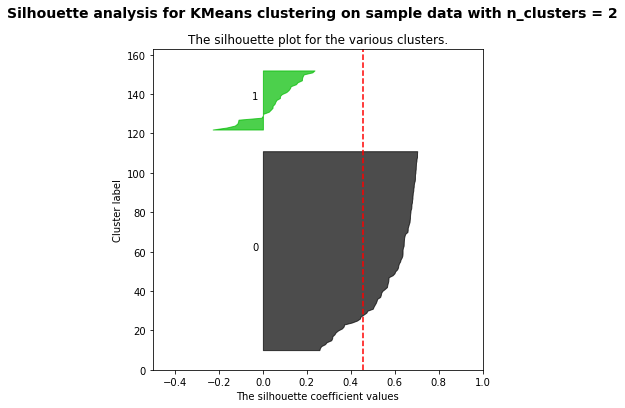

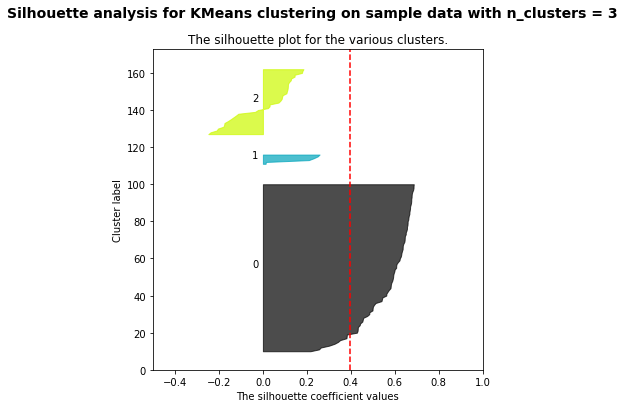

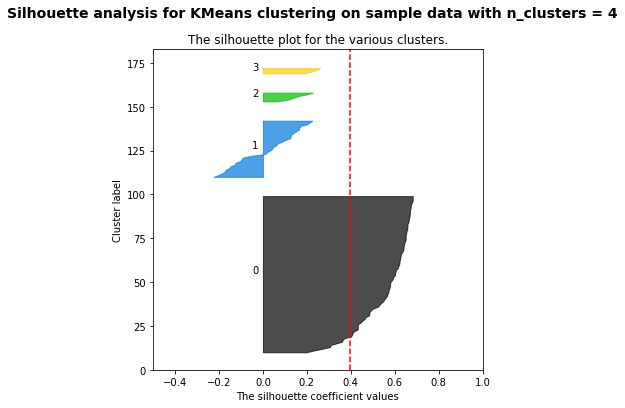

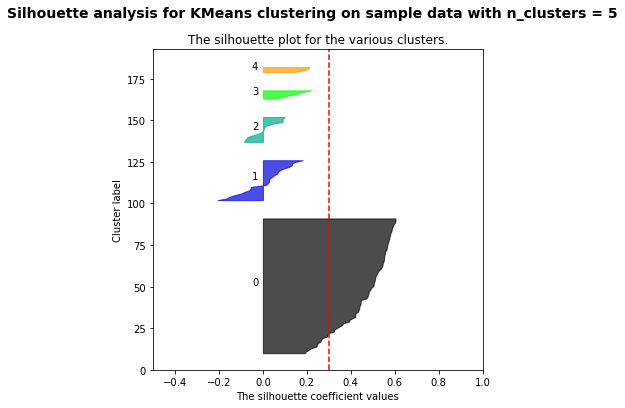

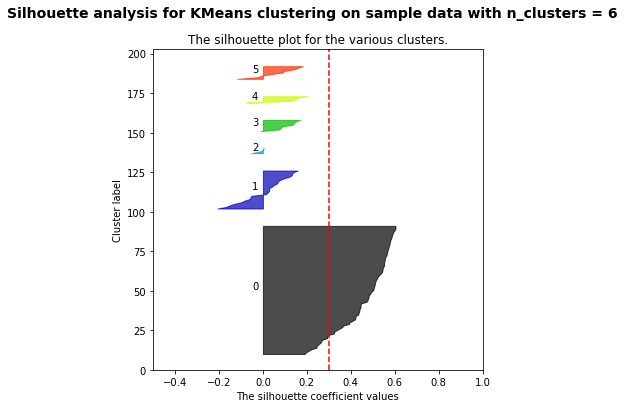

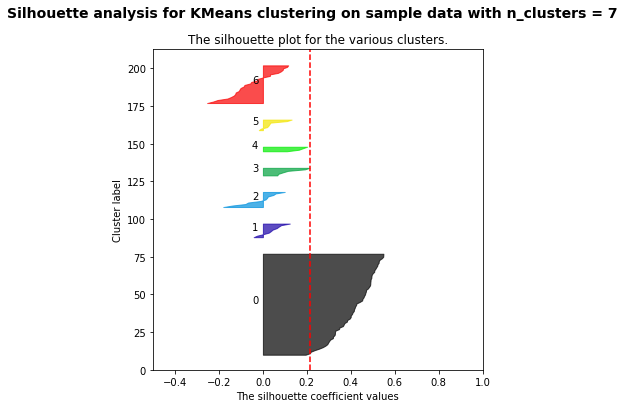

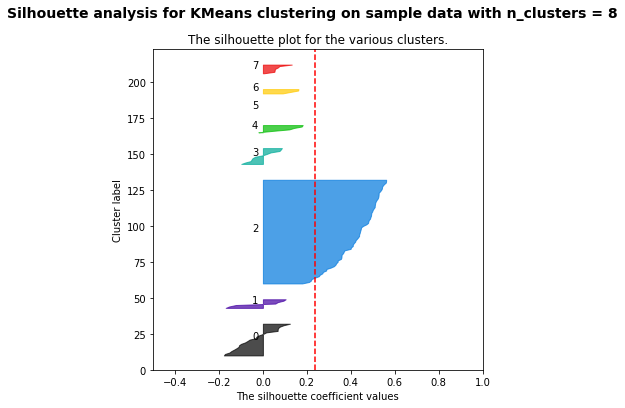

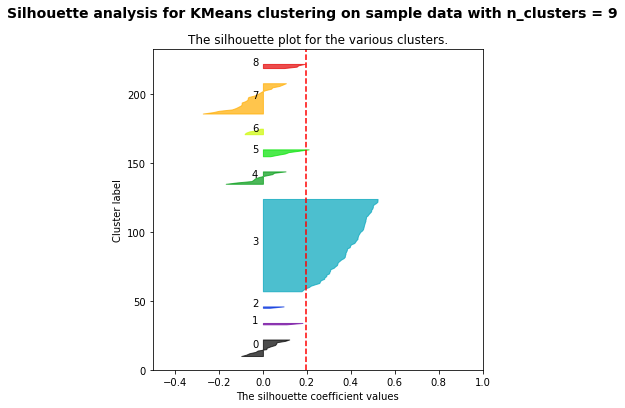

In [11]:
# K-means clustering and silhouette analysis

# Drop 'Neighborhood column for clustering
# Note that we don't furhter normalize the data, as they are already normalized frequency
X = mad_onehot_grouped.iloc[:,1:]

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

clusterer_labels = KMeans_segmentation(range_n_clusters, X)



 #### Segmentation analysis
 Silhouette analyis shows that increasing the number of clusters, decreases the average silhoutte score
 This indicates that clusters are overlapping (sample silhoutte score around zero) and even assigned to
 wrong cluster (negative silhoute sample score). The thickness of the silhoutte seems to indicate that
 there is one main cluster.
 #### Possible improvement
 What if the clustering is done only on the top 15 venues of each neighborhood and we select only
 neighborhoods with at least 15 venues?

For n_clusters = 2 The average silhouette_score is : 0.28318044646892065
For n_clusters = 3 The average silhouette_score is : 0.2750393172605189
For n_clusters = 4 The average silhouette_score is : 0.2815443553908283
For n_clusters = 5 The average silhouette_score is : 0.13621983416757147
For n_clusters = 6 The average silhouette_score is : 0.10429469869833267
For n_clusters = 7 The average silhouette_score is : 0.07356145406986993
For n_clusters = 8 The average silhouette_score is : 0.07739462337400035
For n_clusters = 9 The average silhouette_score is : 0.07504021966585973


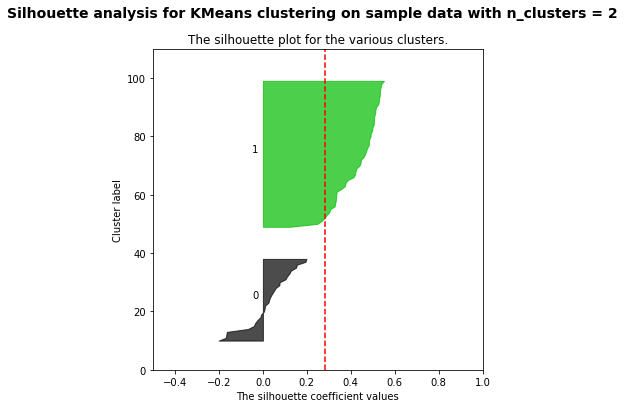

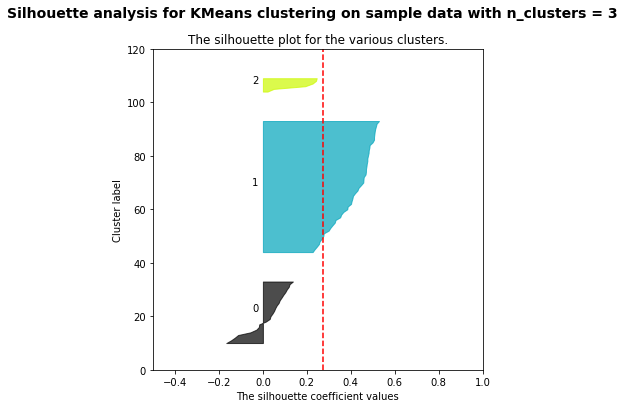

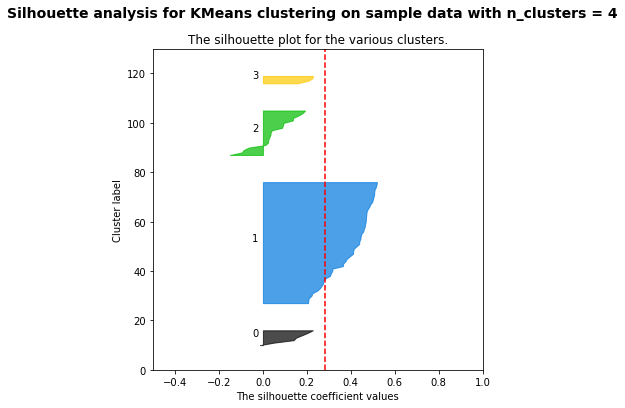

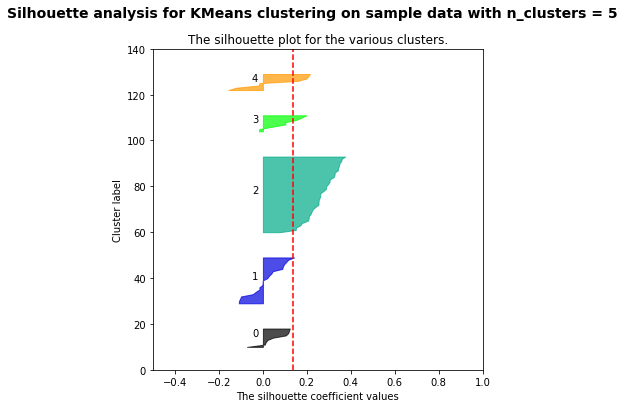

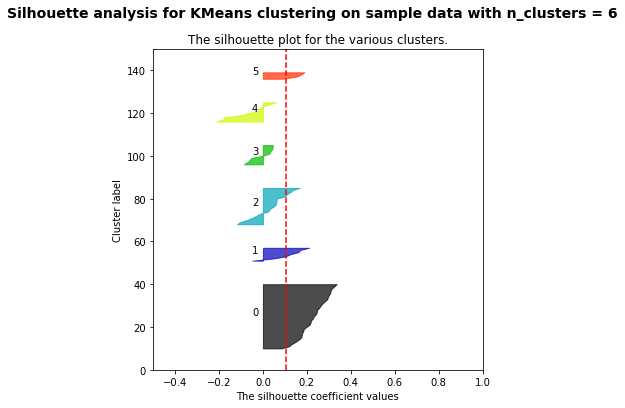

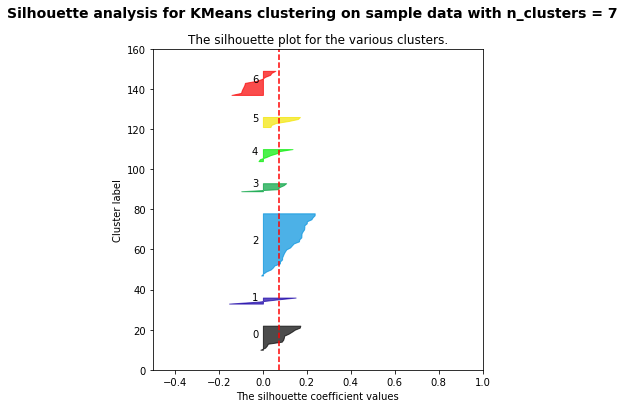

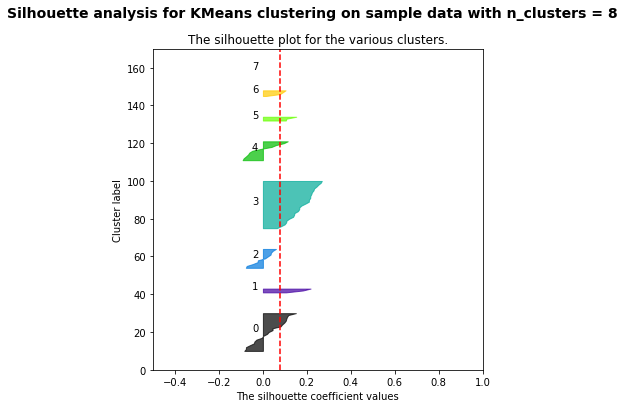

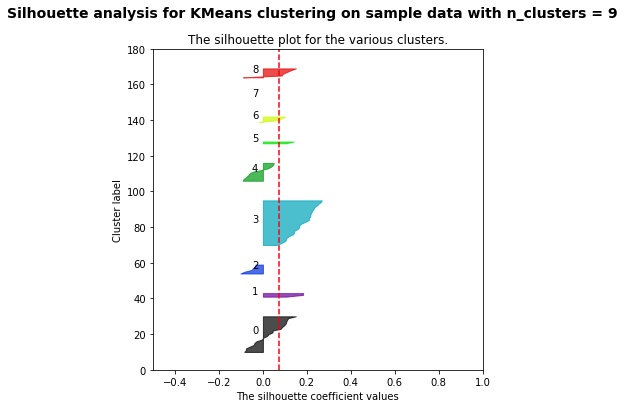

In [12]:
# list of neighborhoods that have at least min_venues top venues
min_venues = 15
min_venues_neigborhoods_list = mad_venues_grouped[mad_venues_grouped['Venue']>min_venues].index.to_list()
mad_venues_min = mad_venues[mad_venues['Neighborhood'].isin(min_venues_neigborhoods_list)]
mad_onehot_grouped_min = mad_onehot_grouped[mad_onehot_grouped['Neighborhood'].isin(min_venues_neigborhoods_list)]

# Clustering for neighborhoods with at least 15 venues
X = mad_onehot_grouped_min.iloc[:,1:]

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

random_state = 0

clusterer_labels = KMeans_segmentation(range_n_clusters, X, random_state)


 Results seem to be worse

 #### Segmentation Analysis
 Filtering out the number of neighborhoods with low amount of venues does not improve the results
 Use all neighborhoods, with 6 clusters and random state = 0

For n_clusters = 6 The average silhouette_score is : 0.33758768653562254


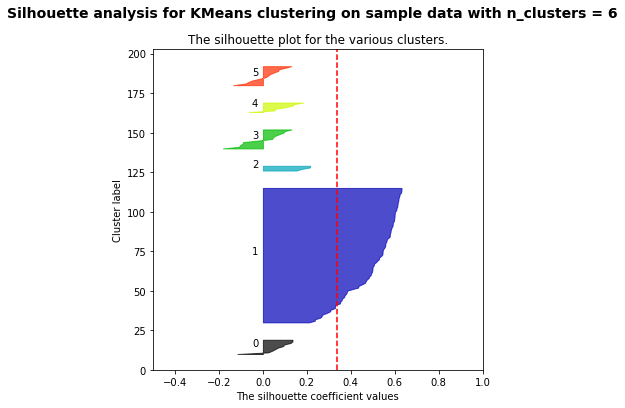


Nothing to be dropped after venue segmentation!

Number of neigborhoods per cluster:
Label
0    10
1    86
2     4
3    13
4     7
5    13
Name: Neighborhood, dtype: int64

Average number of venues per cluster:
Label
0     90.800000
1     14.813953
2    100.000000
3     57.923077
4     97.428571
5     58.692308
dtype: float64


In [13]:
# Assign cluster category to top venues categories in each neighborhood
X = mad_onehot_grouped.iloc[:,1:]
# range_n_clusters = [4]
# rand_num = 1
# clusterer_labels = KMeans_segmentation(range_n_clusters, X, rand_num)

# (next best option)
range_n_clusters = [6]
rand_num = 0
clusterer_labels = KMeans_segmentation(range_n_clusters, X, rand_num)

# insert label in clustering dataframe
try:
    mad_onehot_grouped.drop(columns='Label',inplace=True)
except:
    print("\nNothing to be dropped after venue segmentation!")

mad_onehot_grouped.insert(loc=1,column='Label',value=clusterer_labels)

# how many neighborhoods per cluster?
print(f"\nNumber of neigborhoods per cluster:")
print(f"{mad_onehot_grouped.groupby('Label').count().iloc[:,0]}")

# basic cluster stats: how many venues for each cluster in average?
print(f"\nAverage number of venues per cluster:")
print(f"{mad_onehot_grouped.groupby('Label').mean().sum(axis=1) * (mad_onehot_grouped.shape[1]-2)}")

# create a new dataframe wich contains top venue categories and labels
mad_venues_sorted_labeled = mad_venues_sorted.merge(mad_onehot_grouped[['Neighborhood','Label']],
                                                    how='inner',on='Neighborhood')
# add longitude and latitude
mad_venues_sorted_labeled = mad_venues_sorted_labeled.merge(mad_geodata,
                                                    how='inner',on='Neighborhood')

# create separate dfs for each neighborhood cluster and store in a dict
mad_venues_cluster_dict = create_venue_cluster_dfs(df=mad_venues_sorted_labeled,
                                                   label = 'Label',
                                                   n_clusters = range_n_clusters[0])

# count frequency of venue categories in each cluster and store in a dict
mad_venues_cluster_summary_dict = summarize_venue_cluster_dfs(df_dict=mad_venues_cluster_dict)

# print the map
map_clusters(mad_venues_sorted_labeled, range_n_clusters[0])

 ## Part 3: Madrid's neighborhoods segmented by housing price and demand

 Load data

In [14]:
# Load the consolidate and cleaned data from xlsx file. (xlsx is used as it keeps special charcters)
# import madrid neighborhood demographics and housing prices
mad_demo_prices = pd.read_excel(
    io="/Users/francescofusaro/Documents/GitHub/IBM_DS_Capstone/madrid_merged.xlsx",
    header=0,
    usecols="B:Z",
    sheet_name="merged clean")

print(f"Madrid neighborhood demographics and housing prices imported.\n\
The dataframe has {mad_demo_prices.shape[0]} rows and {mad_demo_prices.shape[1]} columns.")

Madrid neighborhood demographics and housing prices imported.
The dataframe has 134 rows and 25 columns.


In [15]:
# check the datattypes if there are some empty cells in the price_df
print(f"{mad_demo_prices.dtypes}")
print(f"\n{mad_demo_prices.isnull().sum()}")
isnull_rows_prices = mad_demo_prices[mad_demo_prices.isnull()['Quarterly var rent (%)']==True]
isnull_rows_prices.head()

# ensure df consistency (ie same neighborhoods as mad_geodata)
if 'mad_geodata' in locals():
    assert(mad_demo_prices.shape[0]==mad_geodata.shape[0])


Neighborhood               object
District                   object
Area (Ha)                 float64
Density 2018 (Inh/Ha)     float64
Population 2018 (Inh)     float64
Density 2019 (Inh/Ha)     float64
Population 2019 (Inh)     float64
Density 2020 (Inh/Ha)     float64
Population 2020 (Inh)     float64
dDensity 2019 rel (%)     float64
dDensity 2020 rel (%)     float64
Rent price (EUR/m2)       float64
Monthly var rent (%)      float64
Quarterly var rent (%)    float64
Yearly var rent (%)       float64
Max rent (EUR/m2)         float64
Max var rent (%)          float64
Max rent year               int64
Sale price (EUR/m2)       float64
Monthly var sale (%)      float64
Quarterly var sale (%)    float64
Yearly var sale (%)       float64
Max sale (EUR/m2)         float64
Max var sale (%)          float64
Max sale year               int64
dtype: object

Neighborhood              0
District                  0
Area (Ha)                 0
Density 2018 (Inh/Ha)     0
Population 2018 (Inh)  

 ### Exploratory Data Analysis of prices

 #### Boxplot of Feb housing prices by district

In [16]:
# prepare the data
df = mad_demo_prices

# box plot rent
fig = px.box(df, x="District", y="Rent price (EUR/m2)")

fig.show()

# box plot sale
fig = px.box(df, x="District", y="Sale price (EUR/m2)")

fig.show()


 #### correlation and scatter plot matrix
 1. group the features by their pearson correlation coefficient (with respect to y)
   * 1 positive correlation
   * 0 no correlation
   * 1 negative correlation
 2. check the statistical significance with p value
   * p-value is $<$ 0.001: we say there is strong evidence that the correlation is significant
   * the p-value is $<$ 0.05: there is moderate evidence that the correlation is significant
   * the p-value is $<$ 0.1: there is weak evidence that the correlation is significant
   * the p-value is $>$ 0.1: there is no evidence that the correlation is significant

In [17]:
df = df[~df['Neighborhood'].isin(['El Cañaveral','Butarque'])] #exclude outliers
corr = df.iloc[:,3:].corr() #exclude Neighborhood, District, Area


In [18]:
# Rent price vs density
fig = px.scatter_matrix(df,
    dimensions=["Density 2018 (Inh/Ha)", "dDensity 2019 rel (%)", "dDensity 2020 rel (%)", 
                'Rent price (EUR/m2)','Yearly var rent (%)','Max var rent (%)'],
    color="District", symbol="District",
    title="Scatter matrix of Madrid demo prices dataset",
    width=1400, height=1200)
fig.update_traces(diagonal_visible=False)
fig.show()

In [19]:
compute_correlation_bins('Rent price (EUR/m2)')



Correlation coefficient for column: Rent price (EUR/m2)

Empty DataFrame
Columns: [Rent price (EUR/m2), bin]
Index: []

Empty DataFrame
Columns: [Rent price (EUR/m2), bin]
Index: []

                        Rent price (EUR/m2)          bin
Population 2018 (Inh)             -0.177366  neg[0.33-0]
Population 2019 (Inh)             -0.180840  neg[0.33-0]
Population 2020 (Inh)             -0.182688  neg[0.33-0]
dDensity 2019 rel (%)             -0.197200  neg[0.33-0]
dDensity 2020 rel (%)             -0.120766  neg[0.33-0]
Quarterly var rent (%)            -0.037248  neg[0.33-0]
Yearly var rent (%)               -0.189957  neg[0.33-0]
Max var rent (%)                  -0.201412  neg[0.33-0]
Max rent year                     -0.019345  neg[0.33-0]
Monthly var sale (%)              -0.054663  neg[0.33-0]
Quarterly var sale (%)            -0.126154  neg[0.33-0]

                      Rent price (EUR/m2)       bin
Monthly var rent (%)             0.044844  [0-0.33]
Yearly var sale (%)        

In [20]:
compute_correlation_bins('dDensity 2019 rel (%)')



Correlation coefficient for column: dDensity 2019 rel (%)

Empty DataFrame
Columns: [dDensity 2019 rel (%), bin]
Index: []

Empty DataFrame
Columns: [dDensity 2019 rel (%), bin]
Index: []

                        dDensity 2019 rel (%)          bin
Density 2018 (Inh/Ha)               -0.293499  neg[0.33-0]
Population 2018 (Inh)               -0.029607  neg[0.33-0]
Density 2019 (Inh/Ha)               -0.282516  neg[0.33-0]
Population 2019 (Inh)               -0.008316  neg[0.33-0]
Density 2020 (Inh/Ha)               -0.269947  neg[0.33-0]
Rent price (EUR/m2)                 -0.197200  neg[0.33-0]
Max rent (EUR/m2)                   -0.232799  neg[0.33-0]
Sale price (EUR/m2)                 -0.223340  neg[0.33-0]
Monthly var sale (%)                -0.072306  neg[0.33-0]
Quarterly var sale (%)              -0.137907  neg[0.33-0]
Yearly var sale (%)                 -0.029467  neg[0.33-0]
Max sale (EUR/m2)                   -0.202759  neg[0.33-0]
Max var sale (%)                    -0.2265

In [21]:
x_col = 'dDensity 2019 rel (%)'
y_col = 'dDensity 2020 rel (%)'

print(f"\nPearson correlation between {x_col} and {y_col}:")
print(stats.pearsonr(df[x_col], df[y_col]))


Pearson correlation between dDensity 2019 rel (%) and dDensity 2020 rel (%):
(0.8140553079658913, 1.7949414513829525e-32)


In [22]:
compute_correlation_bins('Yearly var rent (%)')



Correlation coefficient for column: Yearly var rent (%)

Empty DataFrame
Columns: [Yearly var rent (%), bin]
Index: []

                       Yearly var rent (%)             bin
Density 2018 (Inh/Ha)            -0.472704  neg[0.67-0.33]
Density 2019 (Inh/Ha)            -0.473570  neg[0.67-0.33]
Density 2020 (Inh/Ha)            -0.475524  neg[0.67-0.33]
Max rent (EUR/m2)                -0.376654  neg[0.67-0.33]

                       Yearly var rent (%)          bin
Population 2018 (Inh)            -0.011964  neg[0.33-0]
Population 2019 (Inh)            -0.006967  neg[0.33-0]
Population 2020 (Inh)            -0.004696  neg[0.33-0]
Rent price (EUR/m2)              -0.189957  neg[0.33-0]
Max rent year                    -0.072858  neg[0.33-0]
Sale price (EUR/m2)              -0.052091  neg[0.33-0]
Yearly var sale (%)              -0.000685  neg[0.33-0]
Max sale (EUR/m2)                -0.014491  neg[0.33-0]
Max var sale (%)                 -0.165231  neg[0.33-0]
Max sale year          

In [23]:
x_col = 'Yearly var rent (%)'
y_col = 'Max var rent (%)'

print(f"\nPearson correlation between {x_col} and {y_col}:")
print(stats.pearsonr(df[x_col], df[y_col]))



Pearson correlation between Yearly var rent (%) and Max var rent (%):
(0.7476851470157758, 7.149028585000754e-25)


In [24]:
# Sale price vs density
fig = px.scatter_matrix(df,
    dimensions=["Density 2018 (Inh/Ha)", "dDensity 2019 rel (%)", "dDensity 2020 rel (%)", 
                'Sale price (EUR/m2)','Yearly var sale (%)','Max var sale (%)'],
    color="District", symbol="District",
    title="Scatter matrix of Madrid demo prices dataset",
    width=1400, height=1200)
fig.update_traces(diagonal_visible=False)
fig.show()

In [25]:
# Sale price vs rent price
fig = px.scatter_matrix(df,
    dimensions=['Rent price (EUR/m2)','Yearly var rent (%)','Max var rent (%)', 
                'Sale price (EUR/m2)','Yearly var sale (%)','Max var sale (%)'],
    color="District", symbol="District",
    title="Scatter matrix of Madrid demo prices dataset",
    width=1400, height=1200)
fig.update_traces(diagonal_visible=False)
fig.show()


In [26]:
compute_correlation_bins('Sale price (EUR/m2)')


Correlation coefficient for column: Sale price (EUR/m2)

Empty DataFrame
Columns: [Sale price (EUR/m2), bin]
Index: []

Empty DataFrame
Columns: [Sale price (EUR/m2), bin]
Index: []

                        Sale price (EUR/m2)          bin
Population 2018 (Inh)             -0.289015  neg[0.33-0]
Population 2019 (Inh)             -0.292519  neg[0.33-0]
Population 2020 (Inh)             -0.295790  neg[0.33-0]
dDensity 2019 rel (%)             -0.223340  neg[0.33-0]
dDensity 2020 rel (%)             -0.194331  neg[0.33-0]
Quarterly var rent (%)            -0.000902  neg[0.33-0]
Yearly var rent (%)               -0.052091  neg[0.33-0]
Max var rent (%)                  -0.109653  neg[0.33-0]
Max rent year                     -0.145818  neg[0.33-0]
Quarterly var sale (%)            -0.036182  neg[0.33-0]

                       Sale price (EUR/m2)       bin
Density 2018 (Inh/Ha)             0.154535  [0-0.33]
Density 2019 (Inh/Ha)             0.149574  [0-0.33]
Density 2020 (Inh/Ha)        

In [27]:
x_col = 'Sale price (EUR/m2)'
y_col = 'Max sale year'

print(f"\nPearson correlation between {x_col} and {y_col}:")
print(stats.pearsonr(df[x_col], df[y_col]))


Pearson correlation between Sale price (EUR/m2) and Max sale year:
(0.6811176530141788, 2.5529707134252036e-19)


In [28]:
x_col = 'Max sale (EUR/m2)'
y_col = 'Max var sale (%)'

print(f"\nPearson correlation between {x_col} and {y_col}:")
print(stats.pearsonr(df[x_col], df[y_col]))



Pearson correlation between Max sale (EUR/m2) and Max var sale (%):
(0.4882246524362893, 2.878550661824934e-09)


In [29]:
x_col = 'Sale price (EUR/m2)'
y_col = 'Max var sale (%)'

print(f"\nPearson correlation between {x_col} and {y_col}:")
print(stats.pearsonr(df[x_col], df[y_col]))



Pearson correlation between Sale price (EUR/m2) and Max var sale (%):
(0.6370587568926438, 2.1817250761219517e-16)


In [30]:
x_col = 'Yearly var sale (%)'
y_col = 'Max var sale (%)'

print(f"\nPearson correlation between {x_col} and {y_col}:")
print(stats.pearsonr(df[x_col], df[y_col]))


Pearson correlation between Yearly var sale (%) and Max var sale (%):
(0.3833503204083242, 5.70503585593905e-06)


In [31]:
x_col = 'Sale price (EUR/m2)'
y_col = 'Max var rent (%)'

print(f"\nPearson correlation between {x_col} and {y_col}:")
print(stats.pearsonr(df[x_col], df[y_col]))


Pearson correlation between Sale price (EUR/m2) and Max var rent (%):
(-0.10965296820120386, 0.21071120204152927)


In [32]:
x_col = 'Rent price (EUR/m2)'
y_col = 'Max var rent (%)'

print(f"\nPearson correlation between {x_col} and {y_col}:")
print(stats.pearsonr(df[x_col], df[y_col]))



Pearson correlation between Rent price (EUR/m2) and Max var rent (%):
(-0.20141200448097202, 0.02056788197305856)


In [33]:
# Sale price vs sale indicators
fig = px.scatter_matrix(df,
    dimensions=['Max sale year', 'Max sale (EUR/m2)',
                'Sale price (EUR/m2)','Yearly var sale (%)','Max var sale (%)'],
    color="District", symbol="District",
    title="Scatter matrix of Madrid demo prices dataset",
    width=1400, height=1200)
fig.update_traces(diagonal_visible=False)
fig.show()


In [34]:
# rent price vs rent indicators
fig = px.scatter_matrix(df,
    dimensions=['Max rent year', 'Max rent (EUR/m2)',
                'Rent price (EUR/m2)','Yearly var rent (%)','Max var rent (%)'],
    color="District", symbol="District",
    title="Scatter matrix of Madrid demo prices dataset",
    width=1400, height=1200)
fig.update_traces(diagonal_visible=False)
fig.show()

In [35]:
df = mad_demo_prices

# box plot rent
fig = px.box(df, x="District", y="Max var rent (%)")

fig.show()

# box plot sale
fig = px.box(df, x="District", y="Max var sale (%)")

fig.show()


 ### Prices segmentation

 #### Prices of houses for rent

For n_clusters = 2 The average silhouette_score is : 0.2643753618227121
For n_clusters = 3 The average silhouette_score is : 0.2823207937661715
For n_clusters = 4 The average silhouette_score is : 0.2958582187880462
For n_clusters = 5 The average silhouette_score is : 0.2912031372567442
For n_clusters = 6 The average silhouette_score is : 0.2709355952640139
For n_clusters = 7 The average silhouette_score is : 0.24017024983608348
For n_clusters = 8 The average silhouette_score is : 0.21450716194041775
For n_clusters = 9 The average silhouette_score is : 0.23746861734948813
For n_clusters = 10 The average silhouette_score is : 0.23272209009438619
For n_clusters = 11 The average silhouette_score is : 0.2443725083437626
For n_clusters = 12 The average silhouette_score is : 0.2437561708806289
For n_clusters = 13 The average silhouette_score is : 0.24047629950568902
For n_clusters = 14 The average silhouette_score is : 0.2459512589026549
For n_clusters = 15 The average silhouette_score is : 

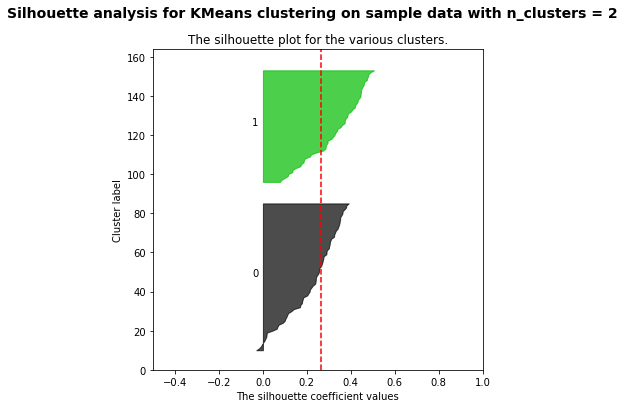

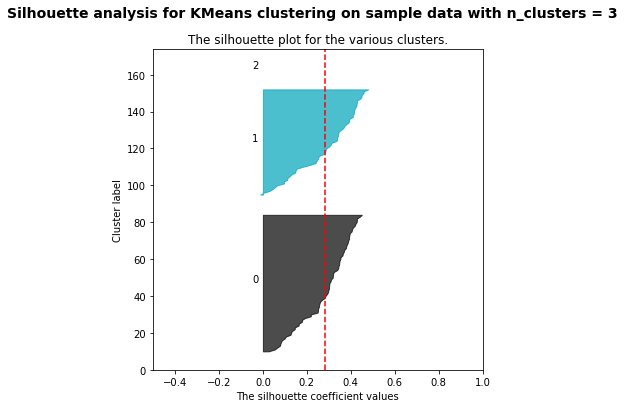

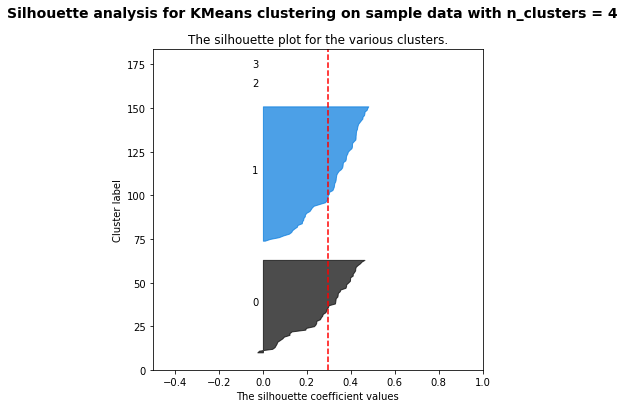

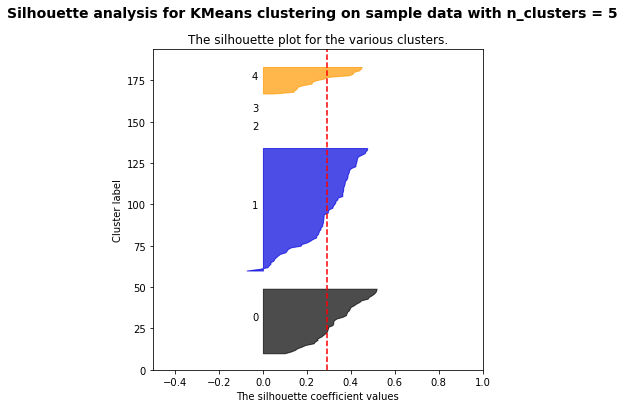

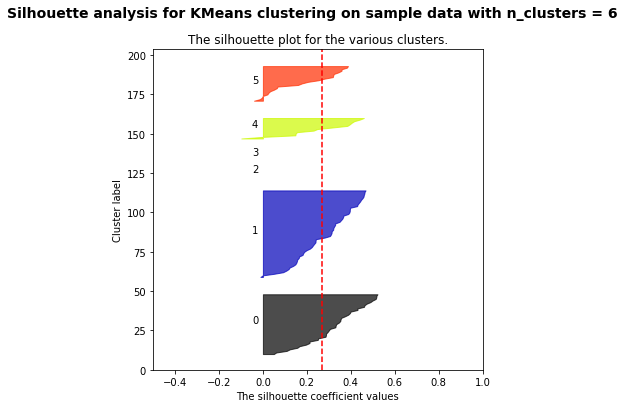

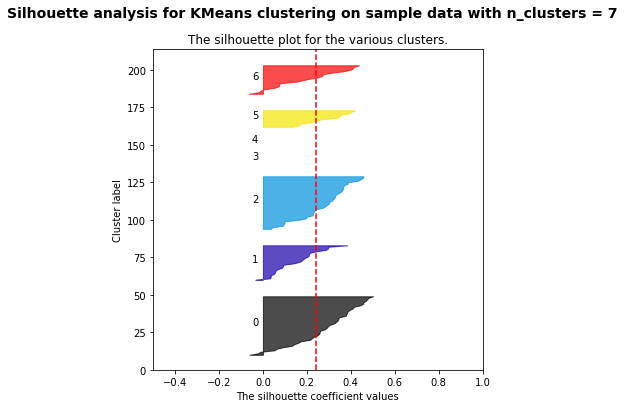

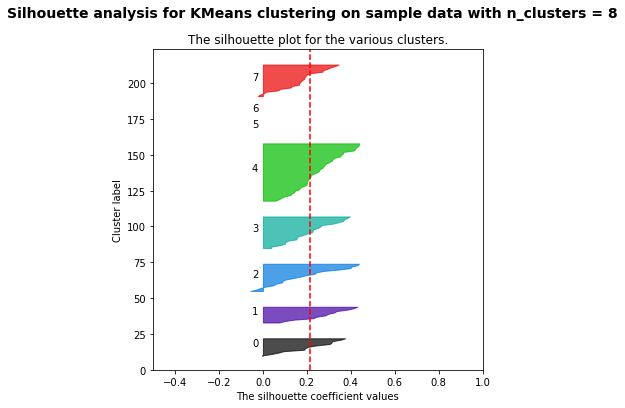

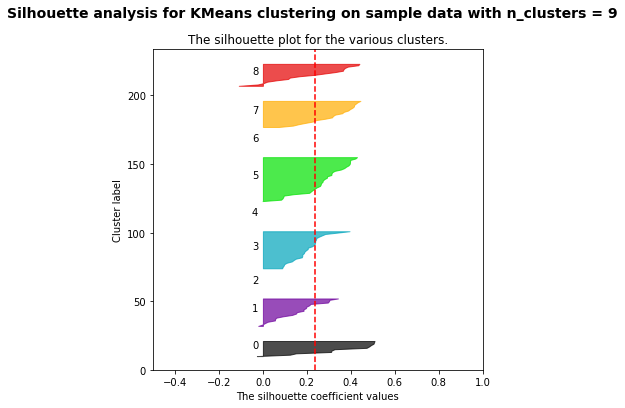

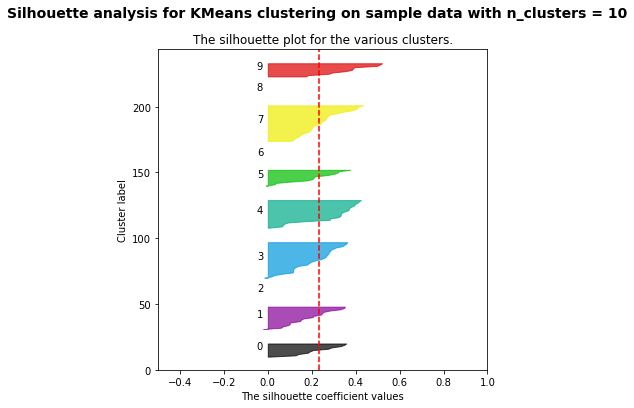

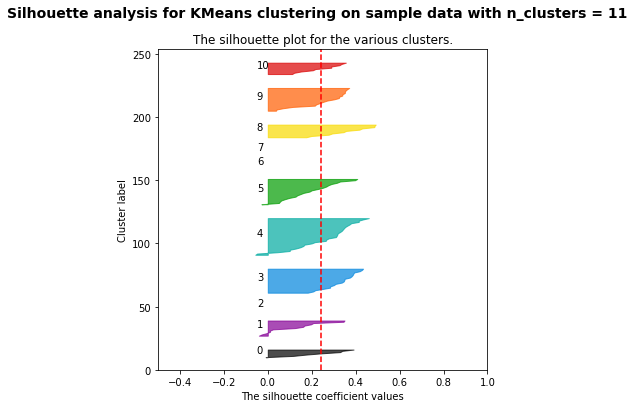

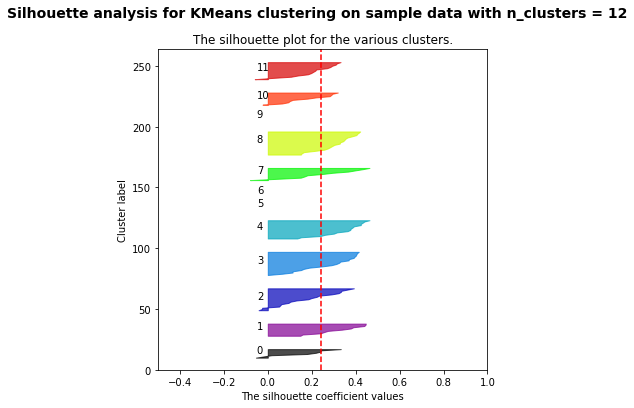

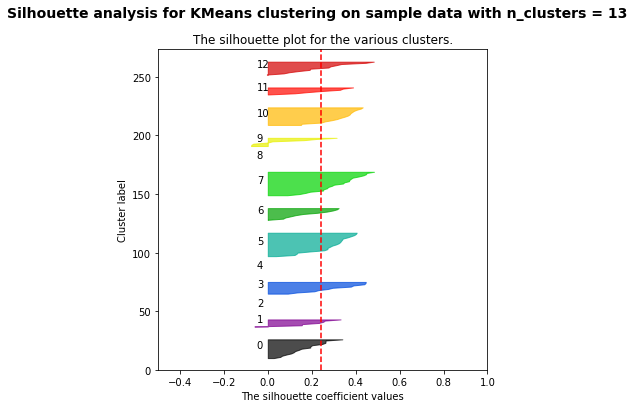

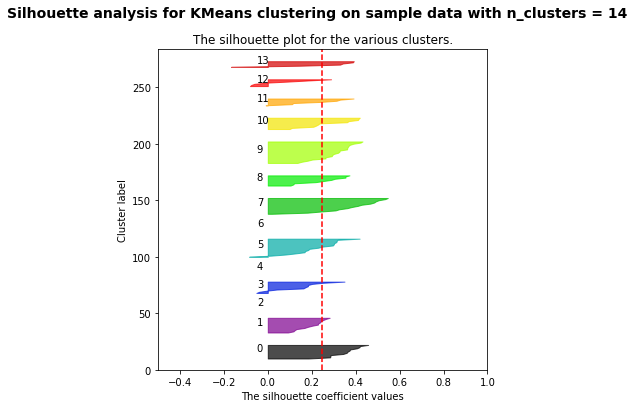

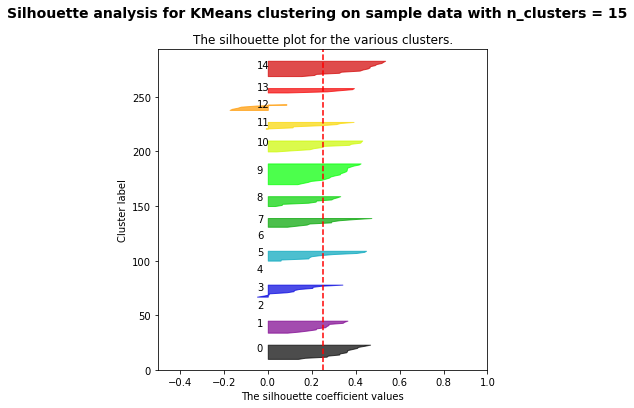

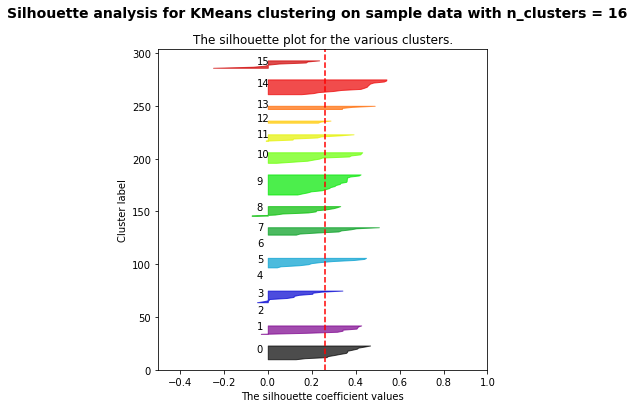

In [36]:
# extract features
X = mad_demo_prices[['dDensity 2019 rel (%)',
                     'dDensity 2020 rel (%)',
                     'Rent price (EUR/m2)',
                     'Max rent year',
                     'Yearly var rent (%)',
                     'Max var rent (%)']]

# scale
X_scaled = StandardScaler().fit_transform(X)

# segment
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

rand = 1

clusterer_labels = KMeans_segmentation(range_n_clusters, X_scaled, rand)


For n_clusters = 10 The average silhouette_score is : 0.23272209009438619


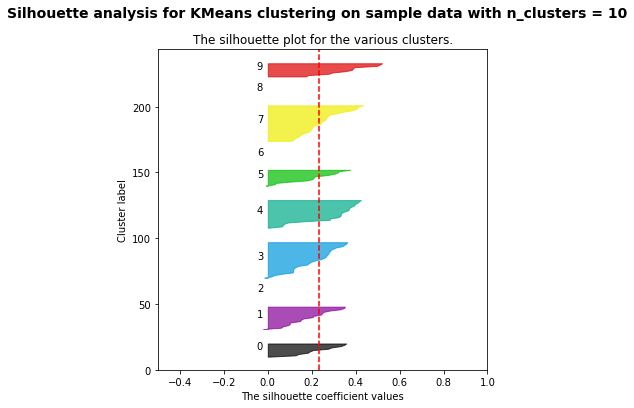

In [37]:
# fix number of clusters
range_n_clusters = [10]
clusterer_labels = KMeans_segmentation(range_n_clusters, X_scaled, rand)

In [38]:
# insert labels
try:
    mad_demo_prices.drop(columns='labels_rent',inplace=True)
except:
    print("nothing to be dropped")

mad_demo_prices.insert(3,'labels_rent',clusterer_labels)
        

nothing to be dropped


In [39]:
# cluster_stats
rent_clusters_dict = create_cluster_dfs(cluster_type='rent',
                                        df = mad_demo_prices,
                                        n_clusters=range_n_clusters[0])

for key, value in rent_clusters_dict.items():
    print(f"\n Stats for cluster {key}:")
    print(f"{value.describe()}")



 Stats for cluster rent_cluster_0:
       dDensity 2019 rel (%)  dDensity 2020 rel (%)  Rent price (EUR/m2)  \
count              11.000000              11.000000            11.000000   
mean                2.741665               2.987951            12.909091   
std                 2.076482               2.183739             1.461817   
min                 0.566383               0.750766            11.700000   
25%                 0.957012               1.232590            12.150000   
50%                 2.567976               2.522836            12.300000   
75%                 3.856883               3.613715            13.100000   
max                 6.604938               7.006369            16.700000   

       Max rent year  Max rent (EUR/m2)  Yearly var rent (%)  Max var rent (%)  
count      11.000000          11.000000            11.000000         11.000000  
mean     2019.636364          13.554545             2.854545         -4.781818  
std         0.504525           1.615

In [40]:
# sort clusters by mean rent price
rent_cluster_grouped = mad_demo_prices.groupby('labels_rent').mean().sort_values('Rent price (EUR/m2)',ascending=False)[[
    'dDensity 2019 rel (%)',
    'dDensity 2020 rel (%)',
    'Rent price (EUR/m2)',
    'Max rent year',
    'Max rent (EUR/m2)',
    'Yearly var rent (%)',
    'Max var rent (%)']]
rent_cluster_grouped.head(15)

dDensity 2019 rel (%)  dDensity 2020 rel (%)  \
labels_rent                                                 
4                         1.160713               2.205246   
1                         0.473723               1.102484   
6                         1.279591               0.189514   
0                         2.741665               2.987951   
3                         1.297499               1.868094   
9                         1.046396               1.514145   
5                         2.139420               2.833069   
7                         1.378331               2.029158   
8                         3.315881               6.114865   
2                        62.921348              56.551724   

             Rent price (EUR/m2)  Max rent year  Max rent (EUR/m2)  \
labels_rent                                                          
4                      15.484091    2019.909091          18.215909   
1                      15.205556    2018.888889          17.566667   
6                      13.100000    2011.000000          14.500000   
0                      12.909091    2019.636364          13.554545   
3                      12.107143    2020.000000          13.396429   
9                      12.063636    2019.636364          15.127273   
5                      11.484615    2018.692308          13.084615   
7                      10.828571    2019.392857          12.371429   
8                      10.300000    2019.000000          16.400000   
2                       9.800000    2020.000000          11.200000   

             Yearly var rent (%)  Max var rent (%)  
labels_rent                                         
4                     -12.729545        -14.915909  
1                      -8.572222        -13.344444  
6                      -7.500000        -10.000000  
0                       2.854545         -4.781818  
3                      -5.396429         -9.467857  
9                     -17.181818        -20.072727  
5                      -1.384615        -12.200000  
7                      -9.603571        -12.317857  
8                      -3.000000        -37.000000  
2                      -8.100000        -12.200000

In [41]:
# plot clusters on map

# add longitude and latitude
mad_rent_labeled = mad_demo_prices.merge(mad_geodata, how='inner',on=['Neighborhood','District'])
mad_rent_labeled.rename(columns={'labels_rent':'Label'},inplace=True)

# plot the map
map_clusters(mad_rent_labeled, range_n_clusters[0])

 #### Prices of houses for sale

For n_clusters = 2 The average silhouette_score is : 0.4268634122300355
For n_clusters = 3 The average silhouette_score is : 0.4421621945153388
For n_clusters = 4 The average silhouette_score is : 0.36447707191617756
For n_clusters = 5 The average silhouette_score is : 0.2759636602599822
For n_clusters = 6 The average silhouette_score is : 0.28270769751590863
For n_clusters = 7 The average silhouette_score is : 0.26098366699380354
For n_clusters = 8 The average silhouette_score is : 0.26886964411243797
For n_clusters = 9 The average silhouette_score is : 0.26889444948007646
For n_clusters = 10 The average silhouette_score is : 0.26645473636016354
For n_clusters = 11 The average silhouette_score is : 0.2646228040211742
For n_clusters = 12 The average silhouette_score is : 0.2771112719929239
For n_clusters = 13 The average silhouette_score is : 0.2632300436604061
For n_clusters = 14 The average silhouette_score is : 0.2801530967642632
For n_clusters = 15 The average silhouette_score is :

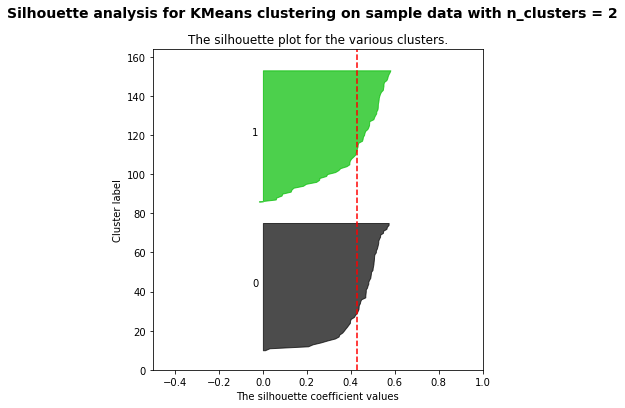

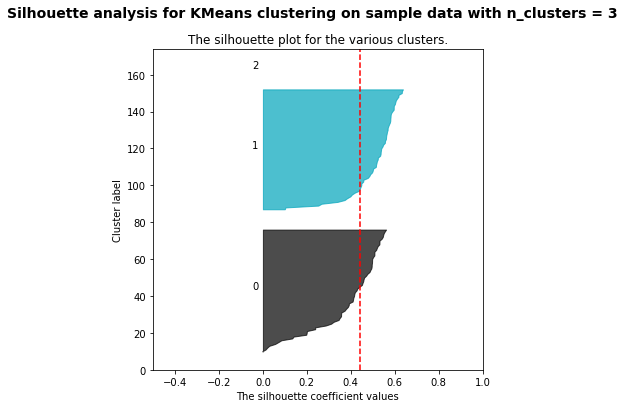

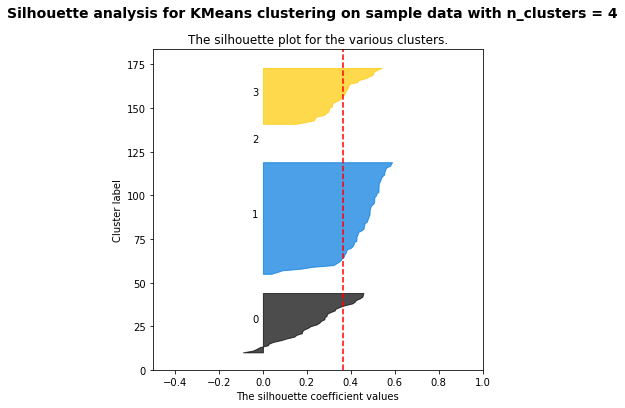

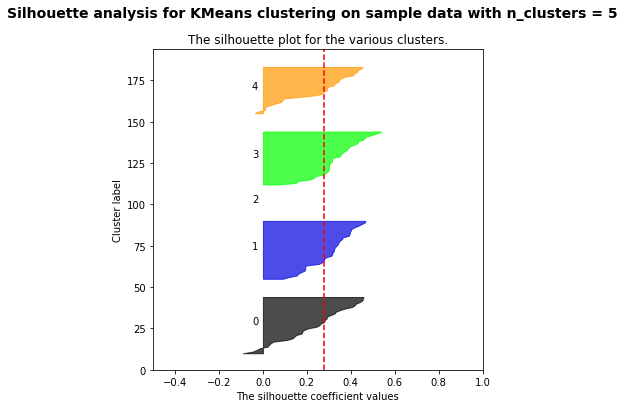

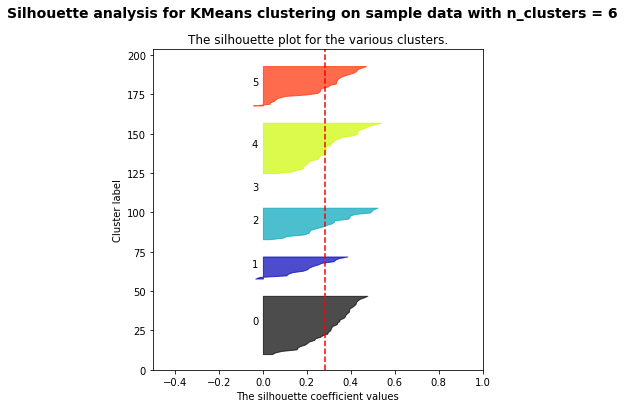

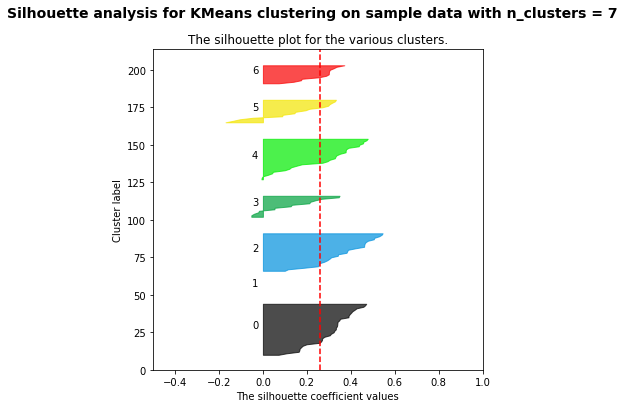

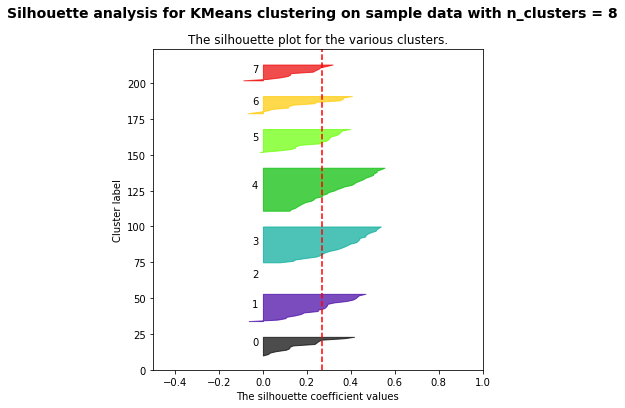

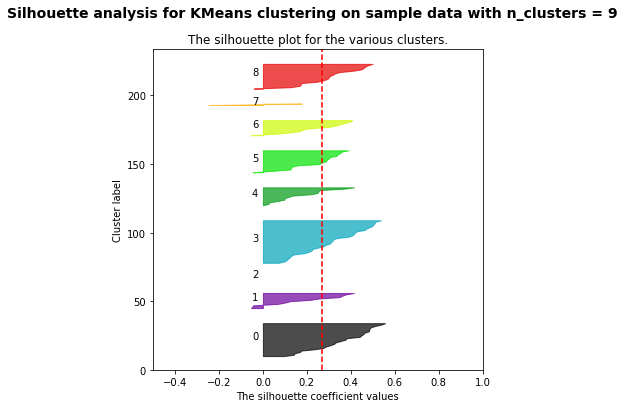

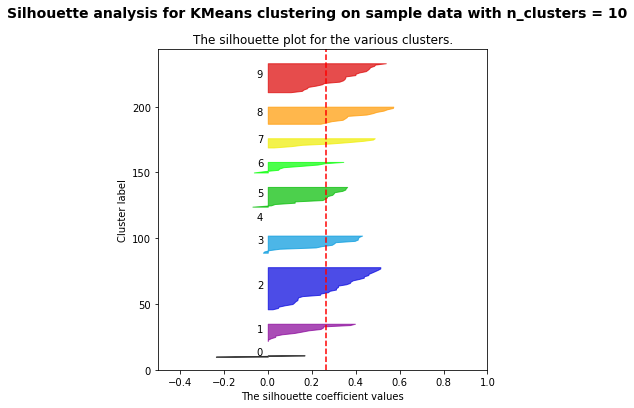

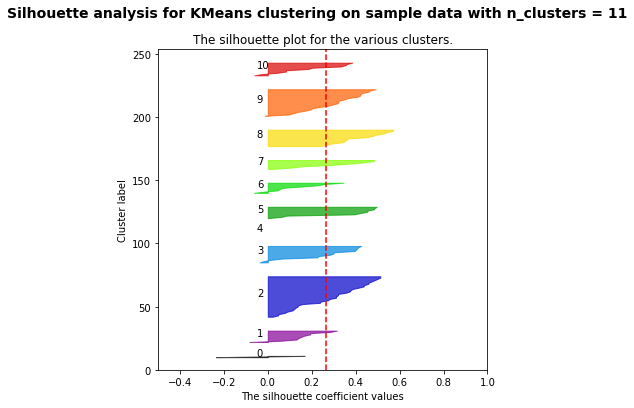

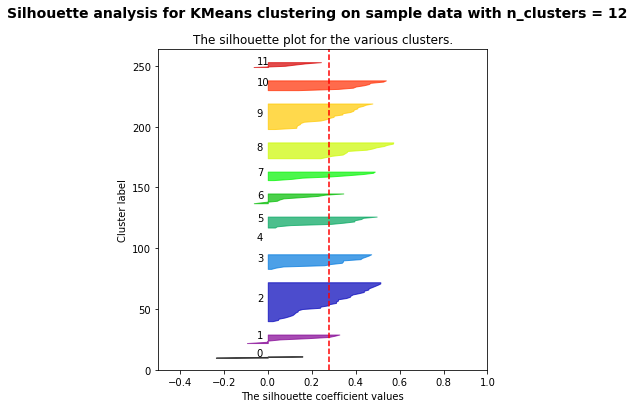

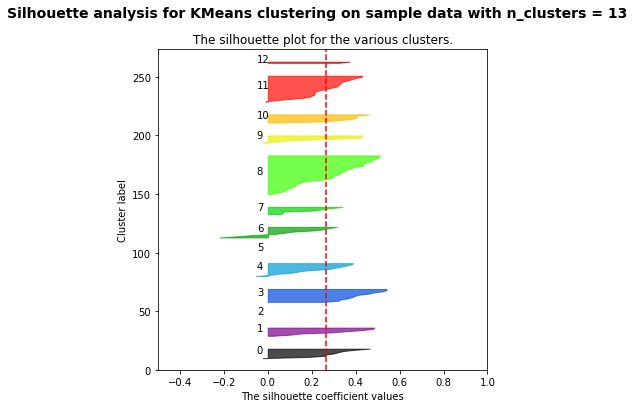

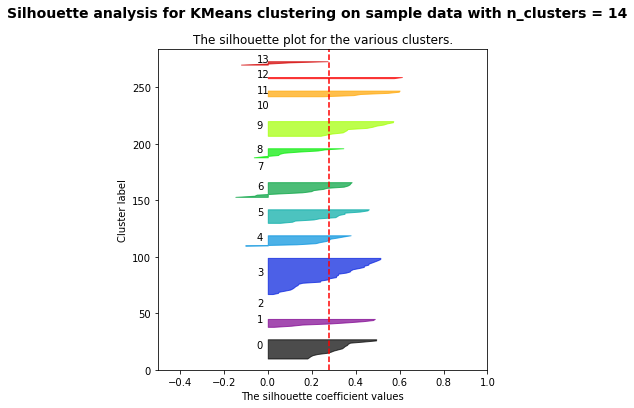

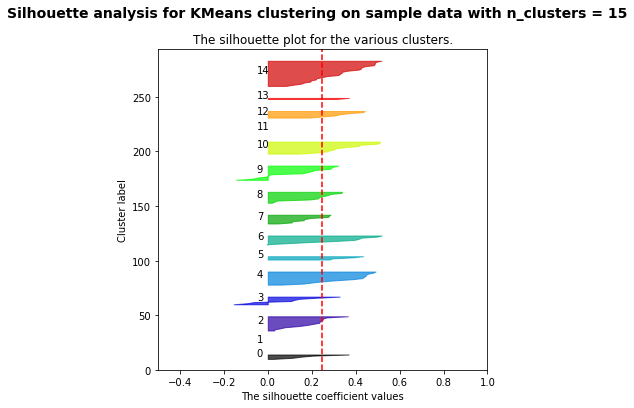

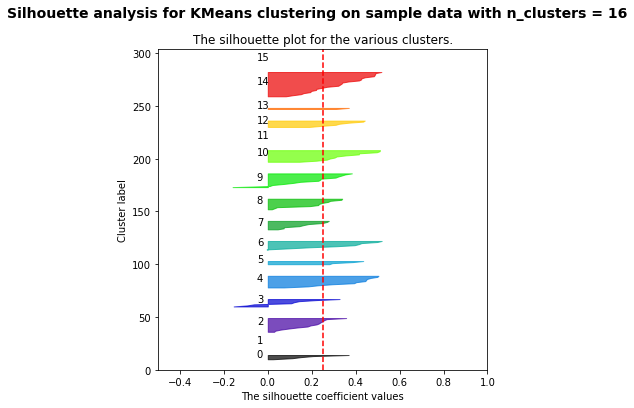

In [42]:
# extract features
X = mad_demo_prices[['dDensity 2019 rel (%)',
                     'dDensity 2020 rel (%)',
                     'Sale price (EUR/m2)',
                     'Max sale year',
                     'Yearly var sale (%)',
                     'Max var sale (%)']]

# scale
X_scaled = StandardScaler().fit_transform(X)

# segment
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

rand = 1

clusterer_labels = KMeans_segmentation(range_n_clusters, X_scaled, rand)


For n_clusters = 14 The average silhouette_score is : 0.2801530967642632


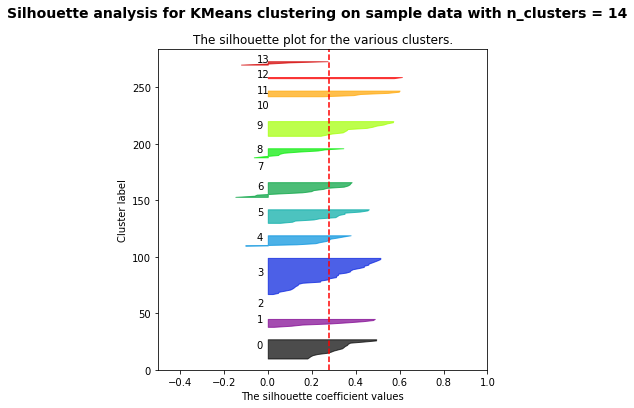

In [43]:
# fix number of clusters
range_n_clusters = [14]
clusterer_labels = KMeans_segmentation(range_n_clusters, X_scaled, rand)

In [44]:
# insert labels
try:
    mad_demo_prices.drop(columns='labels_sale',inplace=True)
except:
    print("nothing to be dropped")

mad_demo_prices.insert(3,'labels_sale',clusterer_labels)


nothing to be dropped


In [45]:
# sort clusters by mean sale price
sale_cluster_grouped = mad_demo_prices.groupby('labels_sale').mean().sort_values('Sale price (EUR/m2)',ascending=False)[[
    'dDensity 2019 rel (%)',
    'dDensity 2020 rel (%)',
    'Sale price (EUR/m2)',
    'Max sale year',
    'Max sale (EUR/m2)',
    'Yearly var sale (%)',
    'Max var sale (%)']]
sale_cluster_grouped.head(15)

dDensity 2019 rel (%)  dDensity 2020 rel (%)  \
labels_sale                                                 
1                         0.711660               1.264288   
8                         0.938122               1.394991   
3                         1.201914               2.030808   
7                         6.604938               7.006369   
9                         0.717031               1.551132   
6                         1.732516               2.068901   
4                         1.404281               1.979179   
2                        62.921348              56.551724   
0                         1.200088               2.016902   
13                        2.372315               2.484418   
10                        1.737708               2.501758   
5                         1.838102               2.333546   
11                        2.013423               2.518891   
12                        2.758600               4.391439   

             Sale price (EUR/m2)  Max sale year  Max sale (EUR/m2)  \
labels_sale                                                          
1                    6398.625000    2019.375000        6879.375000   
8                    5040.777778    2018.555556        5147.000000   
3                    4240.348485    2019.000000        4532.454545   
7                    3678.000000    2018.000000        3914.000000   
9                    3255.714286    2019.785714        3376.571429   
6                    3227.000000    2009.928571        3589.714286   
4                    2799.400000    2010.300000        3312.300000   
2                    2444.000000    2021.000000        2444.000000   
0                    2291.000000    2010.000000        2688.055556   
13                   2213.750000    2014.500000        2620.250000   
10                   2101.000000    2012.000000        2466.000000   
5                    2085.923077    2009.538462        2770.538462   
11                   1806.666667    2010.166667        2499.500000   
12                   1738.000000    2008.500000        2917.000000   

             Yearly var sale (%)  Max var sale (%)  
labels_sale                                         
1                      -3.462500         -7.037500  
8                       3.466667         -2.088889  
3                      -2.313636         -6.330303  
7                       9.200000         -6.000000  
9                       2.450000         -3.442857  
6                       2.578571         -9.678571  
4                      -6.550000        -15.550000  
2                       2.200000          0.000000  
0                      -0.844444        -14.761111  
13                    -12.075000        -15.050000  
10                     17.500000        -14.800000  
5                      -2.430769        -24.684615  
11                     -8.833333        -27.650000  
12                     -1.300000        -40.350000

In [46]:
# plot clusters on map

# add longitude and latitude
mad_sale_labeled = mad_demo_prices.merge(mad_geodata, how='inner',on=['Neighborhood','District'])
mad_sale_labeled.rename(columns={'labels_sale':'Label'},inplace=True)

# plot the map
map_clusters(mad_sale_labeled, range_n_clusters[0])

 #### Prices of houses for sale and rent

For n_clusters = 2 The average silhouette_score is : 0.29147571864548405
For n_clusters = 3 The average silhouette_score is : 0.3025612848662443
For n_clusters = 4 The average silhouette_score is : 0.24723794928026013
For n_clusters = 5 The average silhouette_score is : 0.2560699235290197
For n_clusters = 6 The average silhouette_score is : 0.2246944979759733
For n_clusters = 7 The average silhouette_score is : 0.23244394013165767
For n_clusters = 8 The average silhouette_score is : 0.19459176279671875
For n_clusters = 9 The average silhouette_score is : 0.1718531250099079
For n_clusters = 10 The average silhouette_score is : 0.17075527429506449
For n_clusters = 11 The average silhouette_score is : 0.1703206805469778
For n_clusters = 12 The average silhouette_score is : 0.17401178852813645
For n_clusters = 13 The average silhouette_score is : 0.16322765211947526
For n_clusters = 14 The average silhouette_score is : 0.1831600808970761
For n_clusters = 15 The average silhouette_score is 

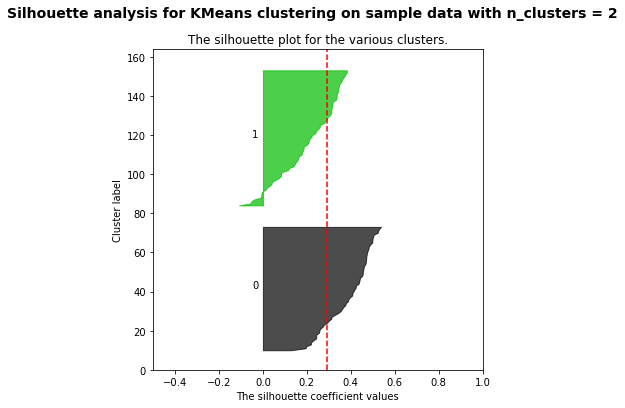

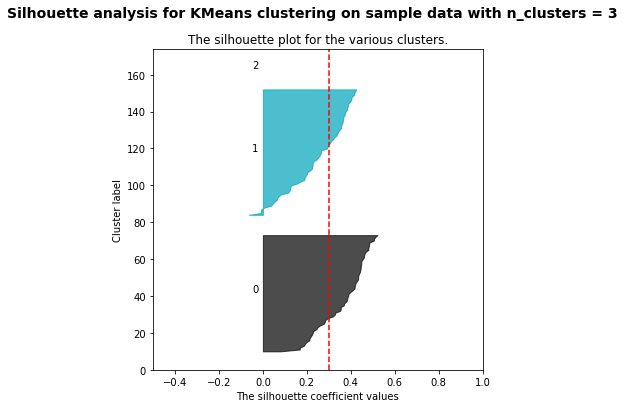

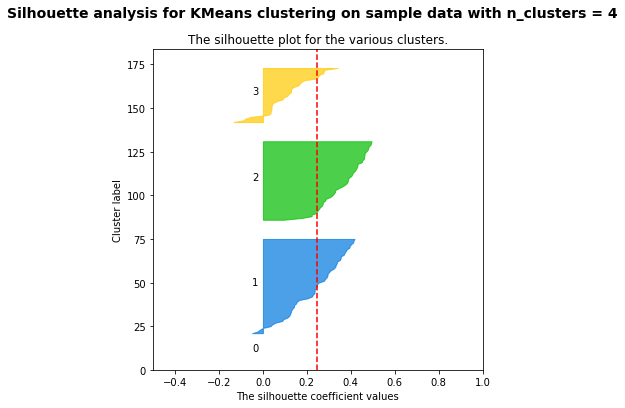

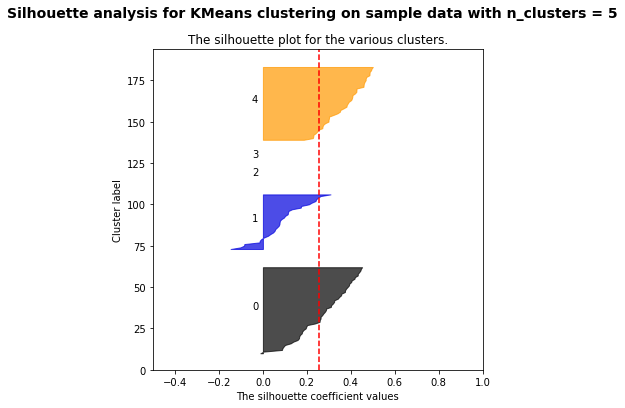

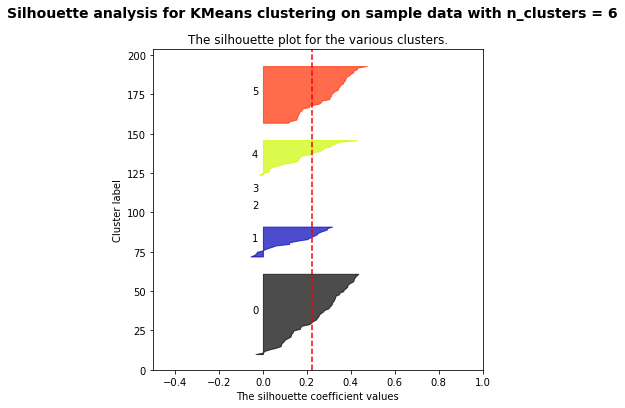

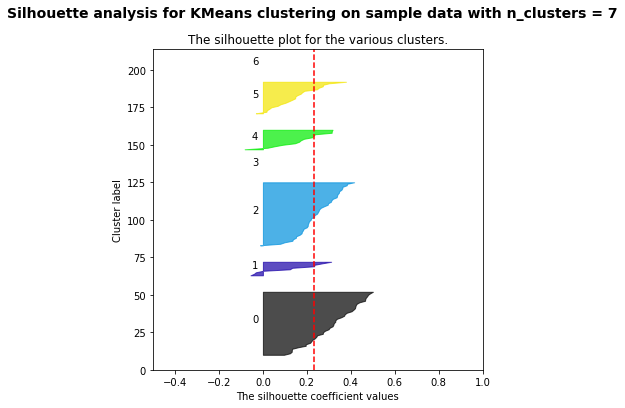

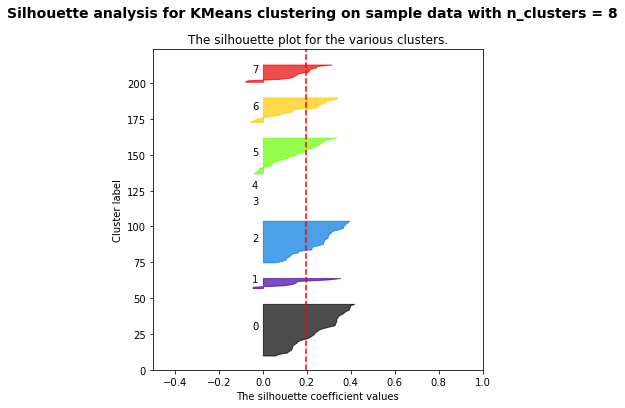

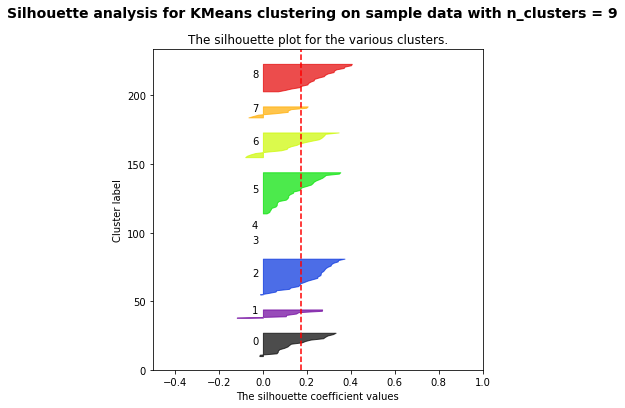

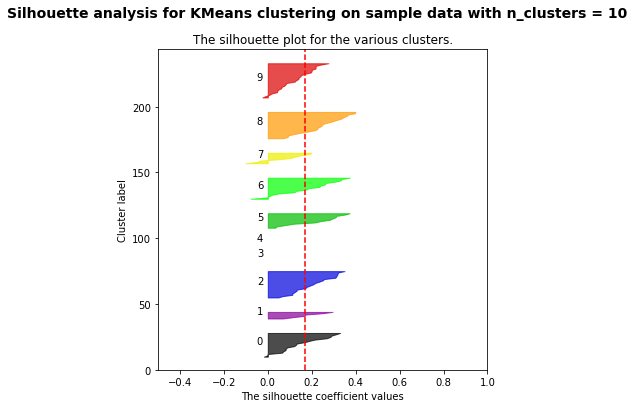

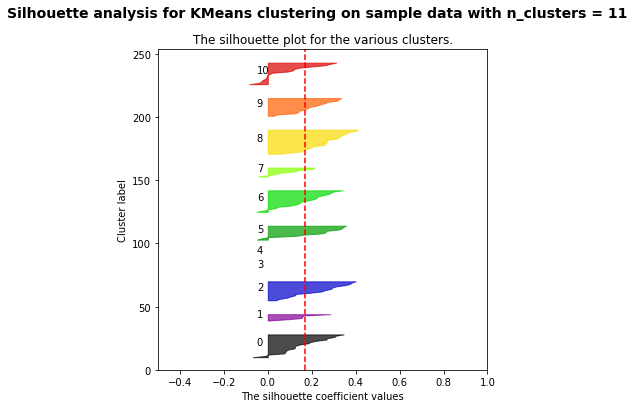

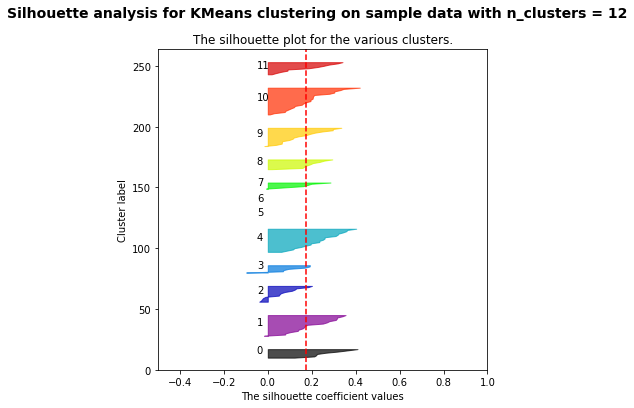

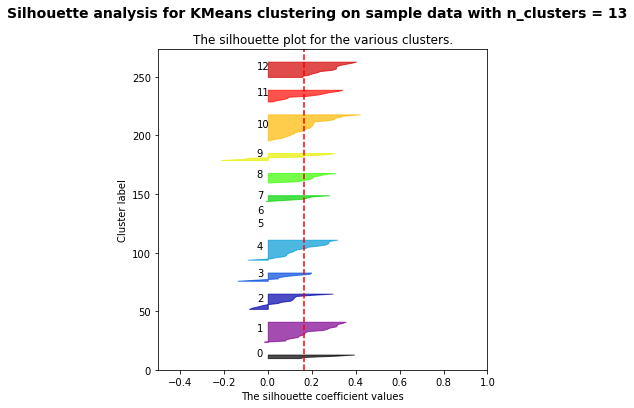

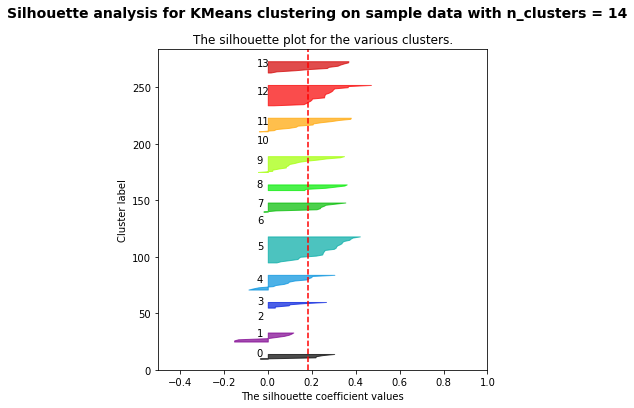

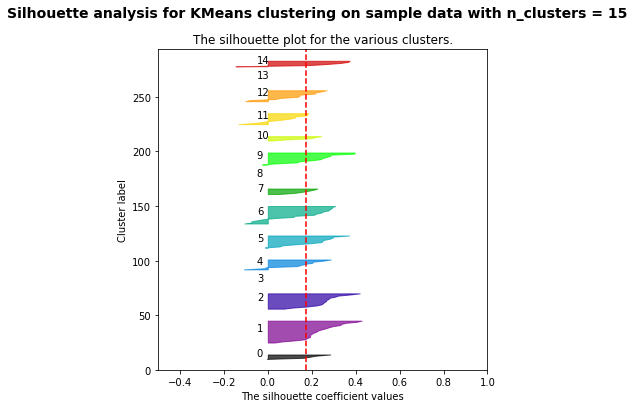

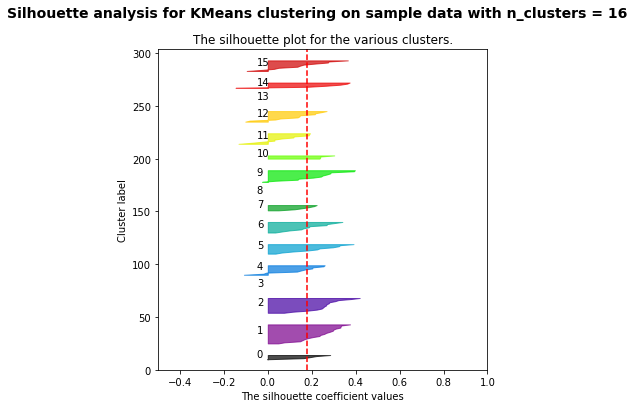

In [47]:
# extract features
X = mad_demo_prices[['dDensity 2019 rel (%)',
                     'dDensity 2020 rel (%)',
                     'Rent price (EUR/m2)',
                     'Max rent year',
                     'Yearly var rent (%)',
                     'Max var rent (%)',
                     'Sale price (EUR/m2)',
                     'Max sale year',
                     'Yearly var sale (%)',
                      'Max var sale (%)']]


# scale
X_scaled = StandardScaler().fit_transform(X)

# segment
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

rand = 1

clusterer_labels = KMeans_segmentation(range_n_clusters, X_scaled, rand)

For n_clusters = 14 The average silhouette_score is : 0.1831600808970761


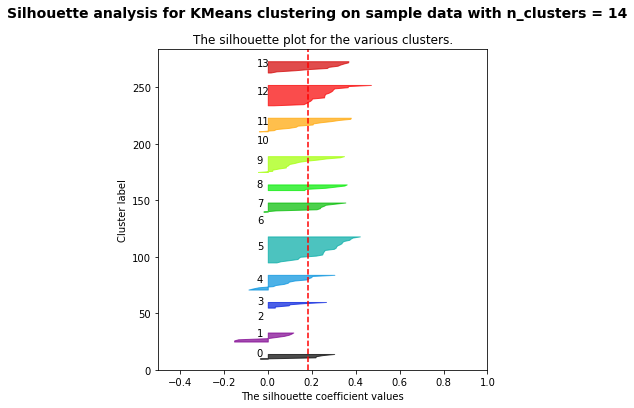

In [48]:
# fix number of clusters
range_n_clusters = [14]
clusterer_labels = KMeans_segmentation(range_n_clusters, X_scaled, rand)

In [49]:
# insert labels
try:
    mad_demo_prices.drop(columns='labels_both',inplace=True)
except:
    print("nothing to be dropped")

mad_demo_prices.insert(3,'labels_both',clusterer_labels)

nothing to be dropped


In [50]:
# sort clusters by mean sale price
sale_rent_cluster_grouped = mad_demo_prices.groupby('labels_both').mean().sort_values('Sale price (EUR/m2)',ascending=False)[[
    'dDensity 2019 rel (%)',
    'dDensity 2020 rel (%)',
    'Sale price (EUR/m2)',
    'Rent price (EUR/m2)',
    'Yearly var sale (%)',
    'Yearly var rent (%)',
    'Max var sale (%)',
    'Max var rent (%)']]
sale_rent_cluster_grouped.head(15)

dDensity 2019 rel (%)  dDensity 2020 rel (%)  \
labels_both                                                 
1                         0.400546               0.791272   
5                         0.982210               1.911839   
6                         1.279591               0.189514   
11                        1.718085               2.138180   
4                         0.772574               1.790371   
7                         2.221896               2.470013   
8                         1.735670               2.341357   
0                         1.261142               1.442458   
2                        62.921348              56.551724   
12                        1.135459               1.833705   
3                         2.033762               2.455455   
9                         1.800652               2.336828   
10                        1.737708               2.501758   
13                        2.019389               3.042367   

             Sale price (EUR/m2)  Rent price (EUR/m2)  Yearly var sale (%)  \
labels_both                                                                  
1                    6219.777778            16.755556            -0.766667   
5                    4649.125000            15.283333            -1.700000   
6                    4257.000000            13.100000             0.900000   
11                   3890.423077            12.907692            -2.407692   
4                    3585.500000            13.075000             2.039286   
7                    3438.000000            12.400000             1.555556   
8                    3328.500000            10.883333             4.166667   
0                    2730.600000            11.220000            -2.900000   
2                    2444.000000             9.800000             2.200000   
12                   2435.736842            11.484211            -0.121053   
3                    2224.666667            11.666667            -3.016667   
9                    2188.000000            11.446667            -8.780000   
10                   2101.000000             9.900000            17.500000   
13                   1894.909091            10.872727            -2.936364   

             Yearly var rent (%)  Max var sale (%)  Max var rent (%)  
labels_both                                                           
1                      -5.477778         -4.644444        -11.177778  
5                     -12.183333         -6.404167        -15.020833  
6                      -7.500000        -18.200000        -10.000000  
11                     -3.023077         -6.042308         -9.700000  
4                     -14.132143         -4.125000        -16.746429  
7                       2.933333        -12.077778         -4.588889  
8                      -7.733333         -1.350000        -12.050000  
0                       0.960000        -17.220000        -13.600000  
2                      -8.100000          0.000000        -12.200000  
12                     -7.273684        -13.300000        -10.421053  
3                     -15.800000        -19.266667        -23.350000  
9                      -7.126667        -18.486667        -11.273333  
10                    -12.600000        -14.800000        -12.600000  
13                     -7.854545        -29.463636        -11.300000

In [51]:
# plot clusters on map

# add longitude and latitude
mad_sale_rent_labeled = mad_demo_prices.merge(mad_geodata, how='inner',on=['Neighborhood','District'])
mad_sale_rent_labeled.rename(columns={'labels_both':'Label'},inplace=True)

# plot the map
map_clusters(mad_sale_rent_labeled, range_n_clusters[0])

In [52]:
# create separate df for each cluster
sale_rent_clusters_dict = create_cluster_dfs(cluster_type='comb',df=mad_demo_prices,n_clusters=range_n_clusters[0])


In [53]:
# box plot of sale prices by sale_rent cluster
print(f"box plot of price of housing for sale by price-rent cluster:")
fig = px.box(mad_sale_rent_labeled, x="Label", y="Sale price (EUR/m2)")

fig.show()


box plot of price of housing for sale by price-rent cluster:


In [54]:
# high level statistics of selected features of entire mad_demo_prices dataset
print(f"High level statistics of selected features of entire mad_demo_prices dataset:")
mad_demo_prices[[
    'dDensity 2019 rel (%)',
    'dDensity 2020 rel (%)',
    'Rent price (EUR/m2)',
    'Max rent year',
    'Max rent (EUR/m2)',
    'Yearly var rent (%)',
    'Max var rent (%)',
    'Sale price (EUR/m2)',
    'Max sale year',
    'Max sale (EUR/m2)',
    'Yearly var sale (%)',
    'Max var sale (%)']].describe()


High level statistics of selected features of entire mad_demo_prices dataset:


dDensity 2019 rel (%)  dDensity 2020 rel (%)  Rent price (EUR/m2)  \
count             134.000000             134.000000           134.000000   
mean                1.835701               2.438002            12.789179   
std                 5.480207               4.947845             2.122679   
min                -0.511991              -0.825397             8.800000   
25%                 0.512274               1.010122            11.300000   
50%                 1.049326               1.678965            12.300000   
75%                 1.974455               2.718837            14.275000   
max                62.921348              56.551724            19.600000   

       Max rent year  Max rent (EUR/m2)  Yearly var rent (%)  \
count     134.000000         134.000000           134.000000   
mean     2019.447761          14.672761            -7.825000   
std         0.977700           2.673193             5.868105   
min      2011.000000           9.800000           -22.800000   
25%      2019.000000          12.625000           -12.037500   
50%      2020.000000          13.900000            -7.850000   
75%      2020.000000          16.400000            -4.200000   
max      2021.000000          23.300000            12.400000   

       Max var rent (%)  Sale price (EUR/m2)  Max sale year  \
count        134.000000           134.000000     134.000000   
mean         -12.459328          3395.436567    2014.619403   
std            4.723562          1309.645322       4.766416   
min          -37.000000          1308.000000    2008.000000   
25%          -14.975000          2183.000000    2010.000000   
50%          -12.200000          3288.500000    2015.000000   
75%           -9.900000          4186.000000    2019.000000   
max           -0.300000          8263.000000    2021.000000   

       Max sale (EUR/m2)  Yearly var sale (%)  Max var sale (%)  
count         134.000000           134.000000        134.000000  
mean         3777.000000            -1.416045        -11.473134  
std          1263.101596             4.454691          8.759986  
min          1727.000000           -14.500000        -41.100000  
25%          2727.750000            -3.575000        -16.875000  
50%          3501.500000            -1.350000         -8.550000  
75%          4466.000000             1.450000         -5.300000  
max          8652.000000            17.500000          0.000000

 ## Part 4: Cross analysis of sale/rent and venue segmentations
 Steps:
 1. Include prices/price segmentation labels in venue clusters
 2. Select neighborhood within venue cluster with lower price level (opporunities)
 3. Plot on map, color by venue cluster, include cluster abels and price in the label

In [55]:
# add sale_rent_clusters labels to venue clusters
mad_venues_prices_labeled = mad_venues_sorted_labeled.merge(
    mad_sale_rent_labeled[['Neighborhood','Label','Sale price (EUR/m2)', 'Rent price (EUR/m2)']], 
    how="inner",
    on='Neighborhood')
mad_venues_prices_labeled.rename(columns={'Label_x':'Label_venue', 'Label_y':'Label_price'},inplace=True)

# create separate dfs for each venue cluster
mad_venues_prices_dict = create_venue_cluster_dfs(df=mad_venues_prices_labeled, 
                                                  label='Label_venue', 
                                                  n_clusters=6)


In [56]:
# select neighborhoods with lower price level for given venue segment (opportunities identified, done manually see report)
opportunities_idx = sorted([95, 123, 54, 16, 17, 35, 44, 108, 112, 125, 2, 10, 18, 31, 36, 63, 81, 96, 99])
mad_neighb_opportunities = mad_venues_prices_labeled.iloc[opportunities_idx]

#print the opportunities df
print(f"\nNeighborhoods with lower price range in given venue cluster:")
mad_neighb_opportunities[[
    'Neighborhood',
    'District',
    'Label_venue',
    'Label_price',
    'Sale price (EUR/m2)',
    'Rent price (EUR/m2)']].head(40).sort_values(by=['Label_venue','Sale price (EUR/m2)'],ascending=True)




Neighborhoods with lower price range in given venue cluster:


Neighborhood             District  Label_venue  Label_price  \
95         Prosperidad            Chamartín            0           11   
123       Vallehermoso             Chamberí            0            4   
54                Goya            Salamanca            2            5   
35            Comillas          Carabanchel            3           12   
112           Simancas  San Blas-Canillejas            3           12   
125             Ventas        Ciudad Lineal            3           12   
44         El Salvador  San Blas-Canillejas            3            7   
17              Atocha           Arganzuela            3            4   
16             Atalaya        Ciudad Lineal            3           11   
108  San Juan Bautista        Ciudad Lineal            3           11   
96        Pueblo Nuevo        Ciudad Lineal            5           12   
99            Quintana        Ciudad Lineal            5           12   
36          Concepción        Ciudad Lineal            5            9   
10    Apóstol Santiago            Hortaleza            5            8   
18       Bellas Vistas               Tetuán            5            4   
31             Chopera           Arganzuela            5            4   
81            Pacífico               Retiro            5           11   
2              Adelfas               Retiro            5            4   
63          Las Tablas  Fuencarral-El Pardo            5           11   

     Sale price (EUR/m2)  Rent price (EUR/m2)  
95                4228.0                14.40  
123               4953.0                15.20  
54                5599.0                16.50  
35                2565.0                12.20  
112               2633.0                11.80  
125               2663.0                12.00  
44                3311.0                12.20  
17                3915.0                14.15  
16                4132.5                14.40  
108               4151.0                13.30  
96                2506.0                12.10  
99                2909.0                12.50  
36                2942.0                13.10  
10                2983.0                10.80  
18                3440.0                14.30  
31                3641.0                14.00  
81                3976.0                14.20  
2                 4077.0                13.80  
63                4130.0                12.00

In [57]:
# plot the opportunities on a map
# print the map
map_opportunities(df=mad_neighb_opportunities, kclusters=6)